In [29]:
# Стандартные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Масштабирование, поиск гиперпараметров, метрики
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# C целью избежания лишних выводов
import warnings
warnings.filterwarnings('ignore')

# Для выгрузки модели
import joblib

------
------

## ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).

----
----

-----
-----

# EDA (исследование данных)

In [30]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [4]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [6]:
# Уникальные значения для категориальных колонок
for col in df.columns:
    if col not in df.describe().columns:
        print(f"Column {col} has {df[col].unique()}")

Column customerID has ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column gender has ['Female' 'Male']
Column Partner has ['Yes' 'No']
Column Dependents has ['No' 'Yes']
Column PhoneService has ['No' 'Yes']
Column MultipleLines has ['No phone service' 'No' 'Yes']
Column InternetService has ['DSL' 'Fiber optic' 'No']
Column OnlineSecurity has ['No' 'Yes' 'No internet service']
Column OnlineBackup has ['Yes' 'No' 'No internet service']
Column DeviceProtection has ['No' 'Yes' 'No internet service']
Column TechSupport has ['No' 'Yes' 'No internet service']
Column StreamingTV has ['No' 'Yes' 'No internet service']
Column StreamingMovies has ['No' 'Yes' 'No internet service']
Column Contract has ['Month-to-month' 'One year' 'Two year']
Column PaperlessBilling has ['Yes' 'No']
Column PaymentMethod has ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Column Churn has ['No' 'Yes']


In [7]:
# Пропущенные значения
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Дублированные значения
df[df.duplicated()]

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]

## Наличие выбросов в данных

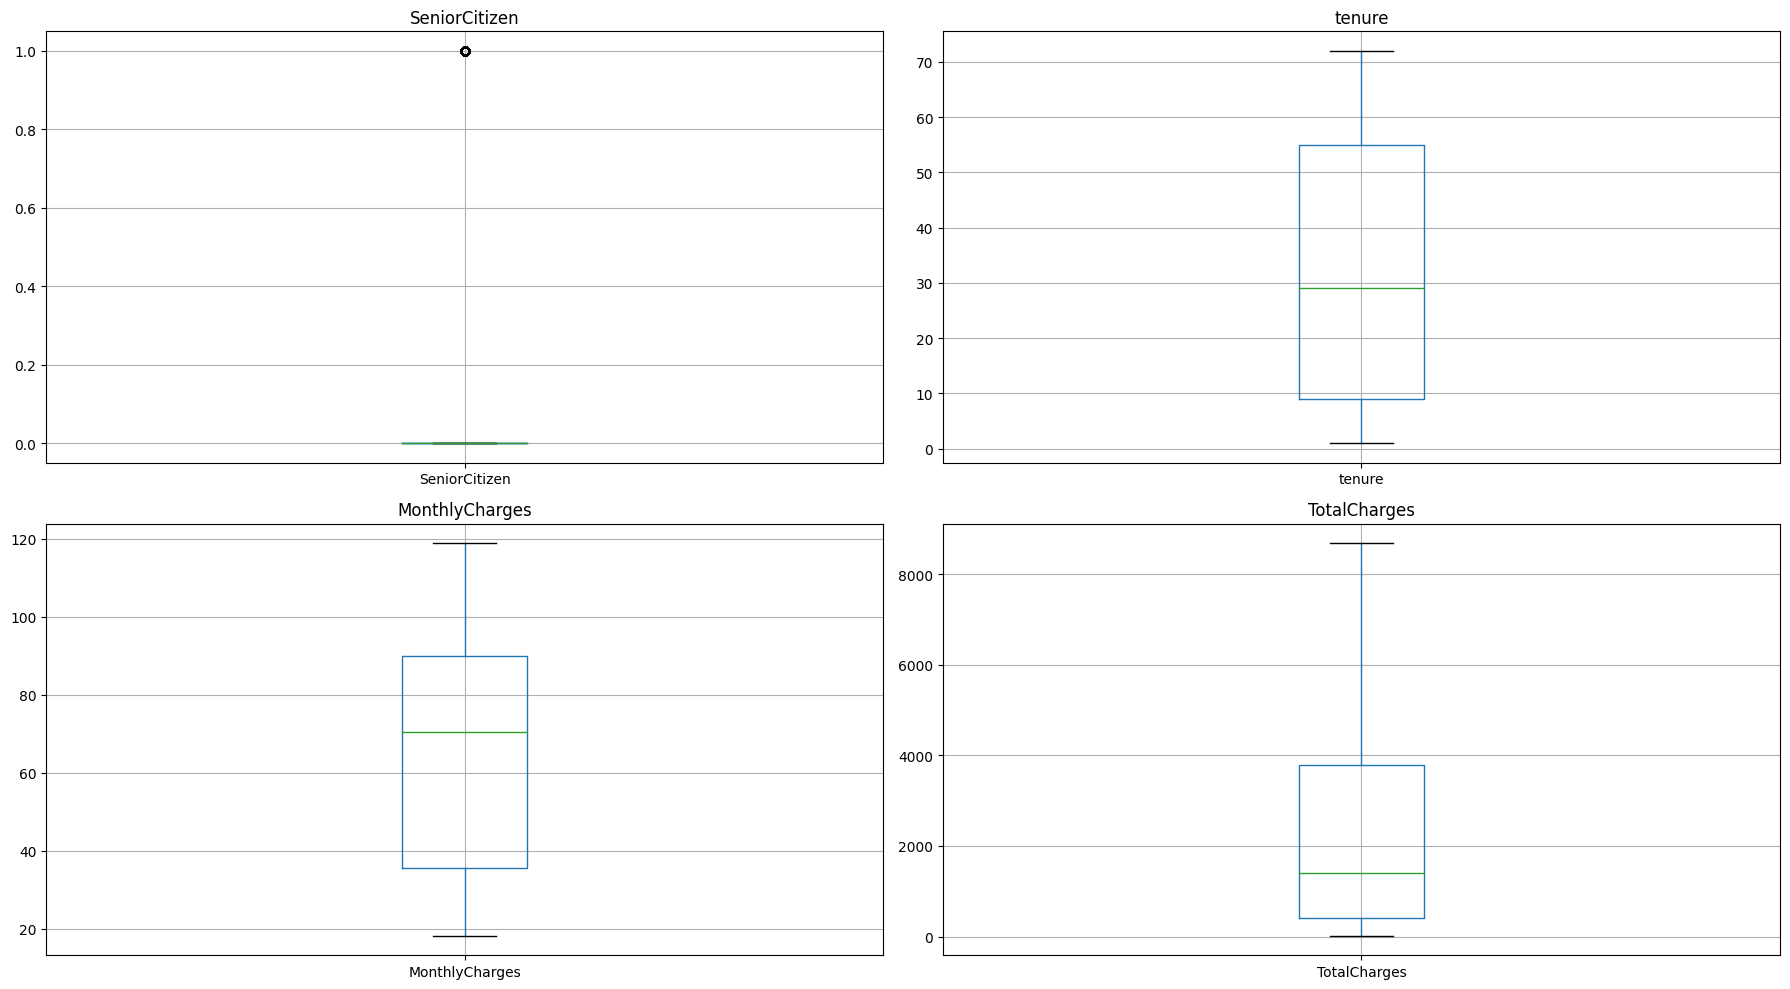

In [9]:
n_features = 4
n_cols = 2
n_rows = np.ceil(n_features / n_cols).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
ax = ax.flatten()
for i, feature in enumerate(df.describe()):
    if feature in df.describe().columns:
        df[[feature]].boxplot(ax=ax[i])
        ax[i].set_title(feature)
plt.tight_layout()
plt.show()

**Мы видим, что ярковыраженных выбросов нет, поэтому не стоит как-то дополнительно обрабатывать эти случаи**

## Корреляции между переменными

In [10]:
corr_df = df.drop('customerID', axis=1)
corr_df = pd.get_dummies(corr_df, drop_first=True)
corr_df = corr_df.rename(columns={'Churn_Yes': 'Churn'})

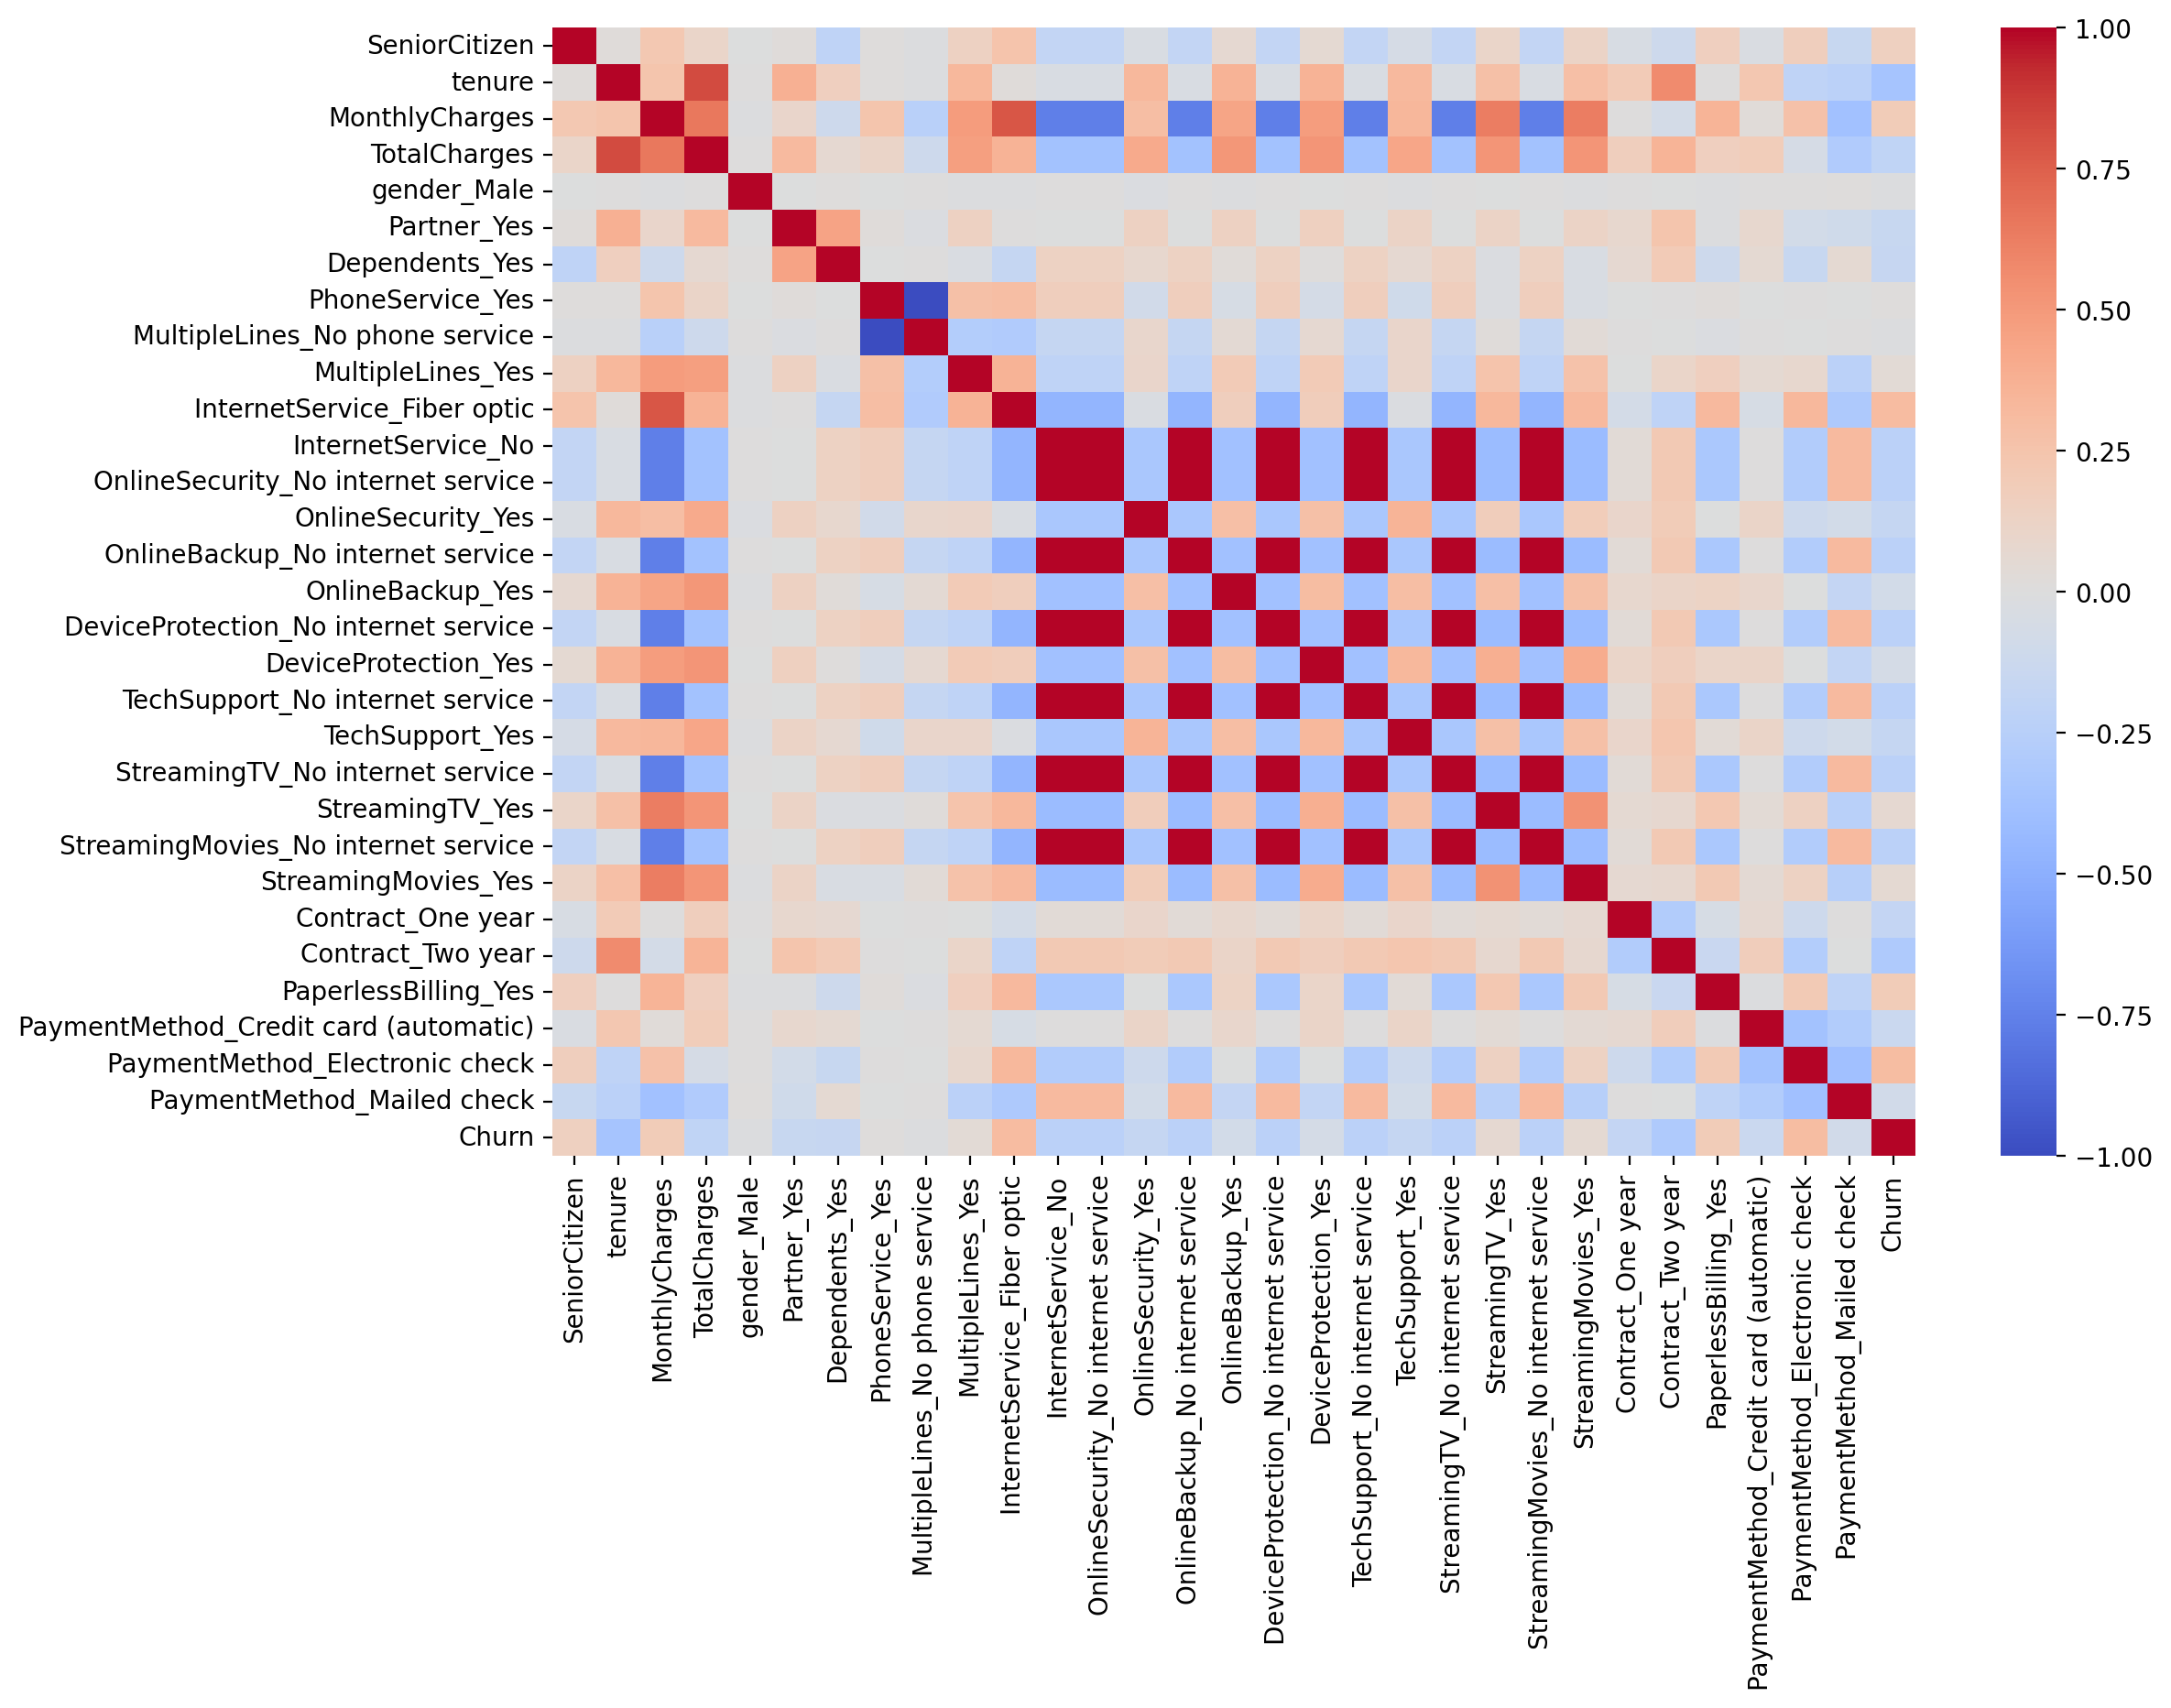

In [11]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(corr_df.corr(), cmap='coolwarm');

## Корреляции с целевой переменной

In [12]:
corr_df = df.drop('customerID', axis=1)
corr_df['Churn'] = corr_df['Churn'].map({'No': 0, 'Yes': 1})
corr_df = pd.get_dummies(corr_df)
churn = corr_df.corr()['Churn'].sort_values()[:-1]

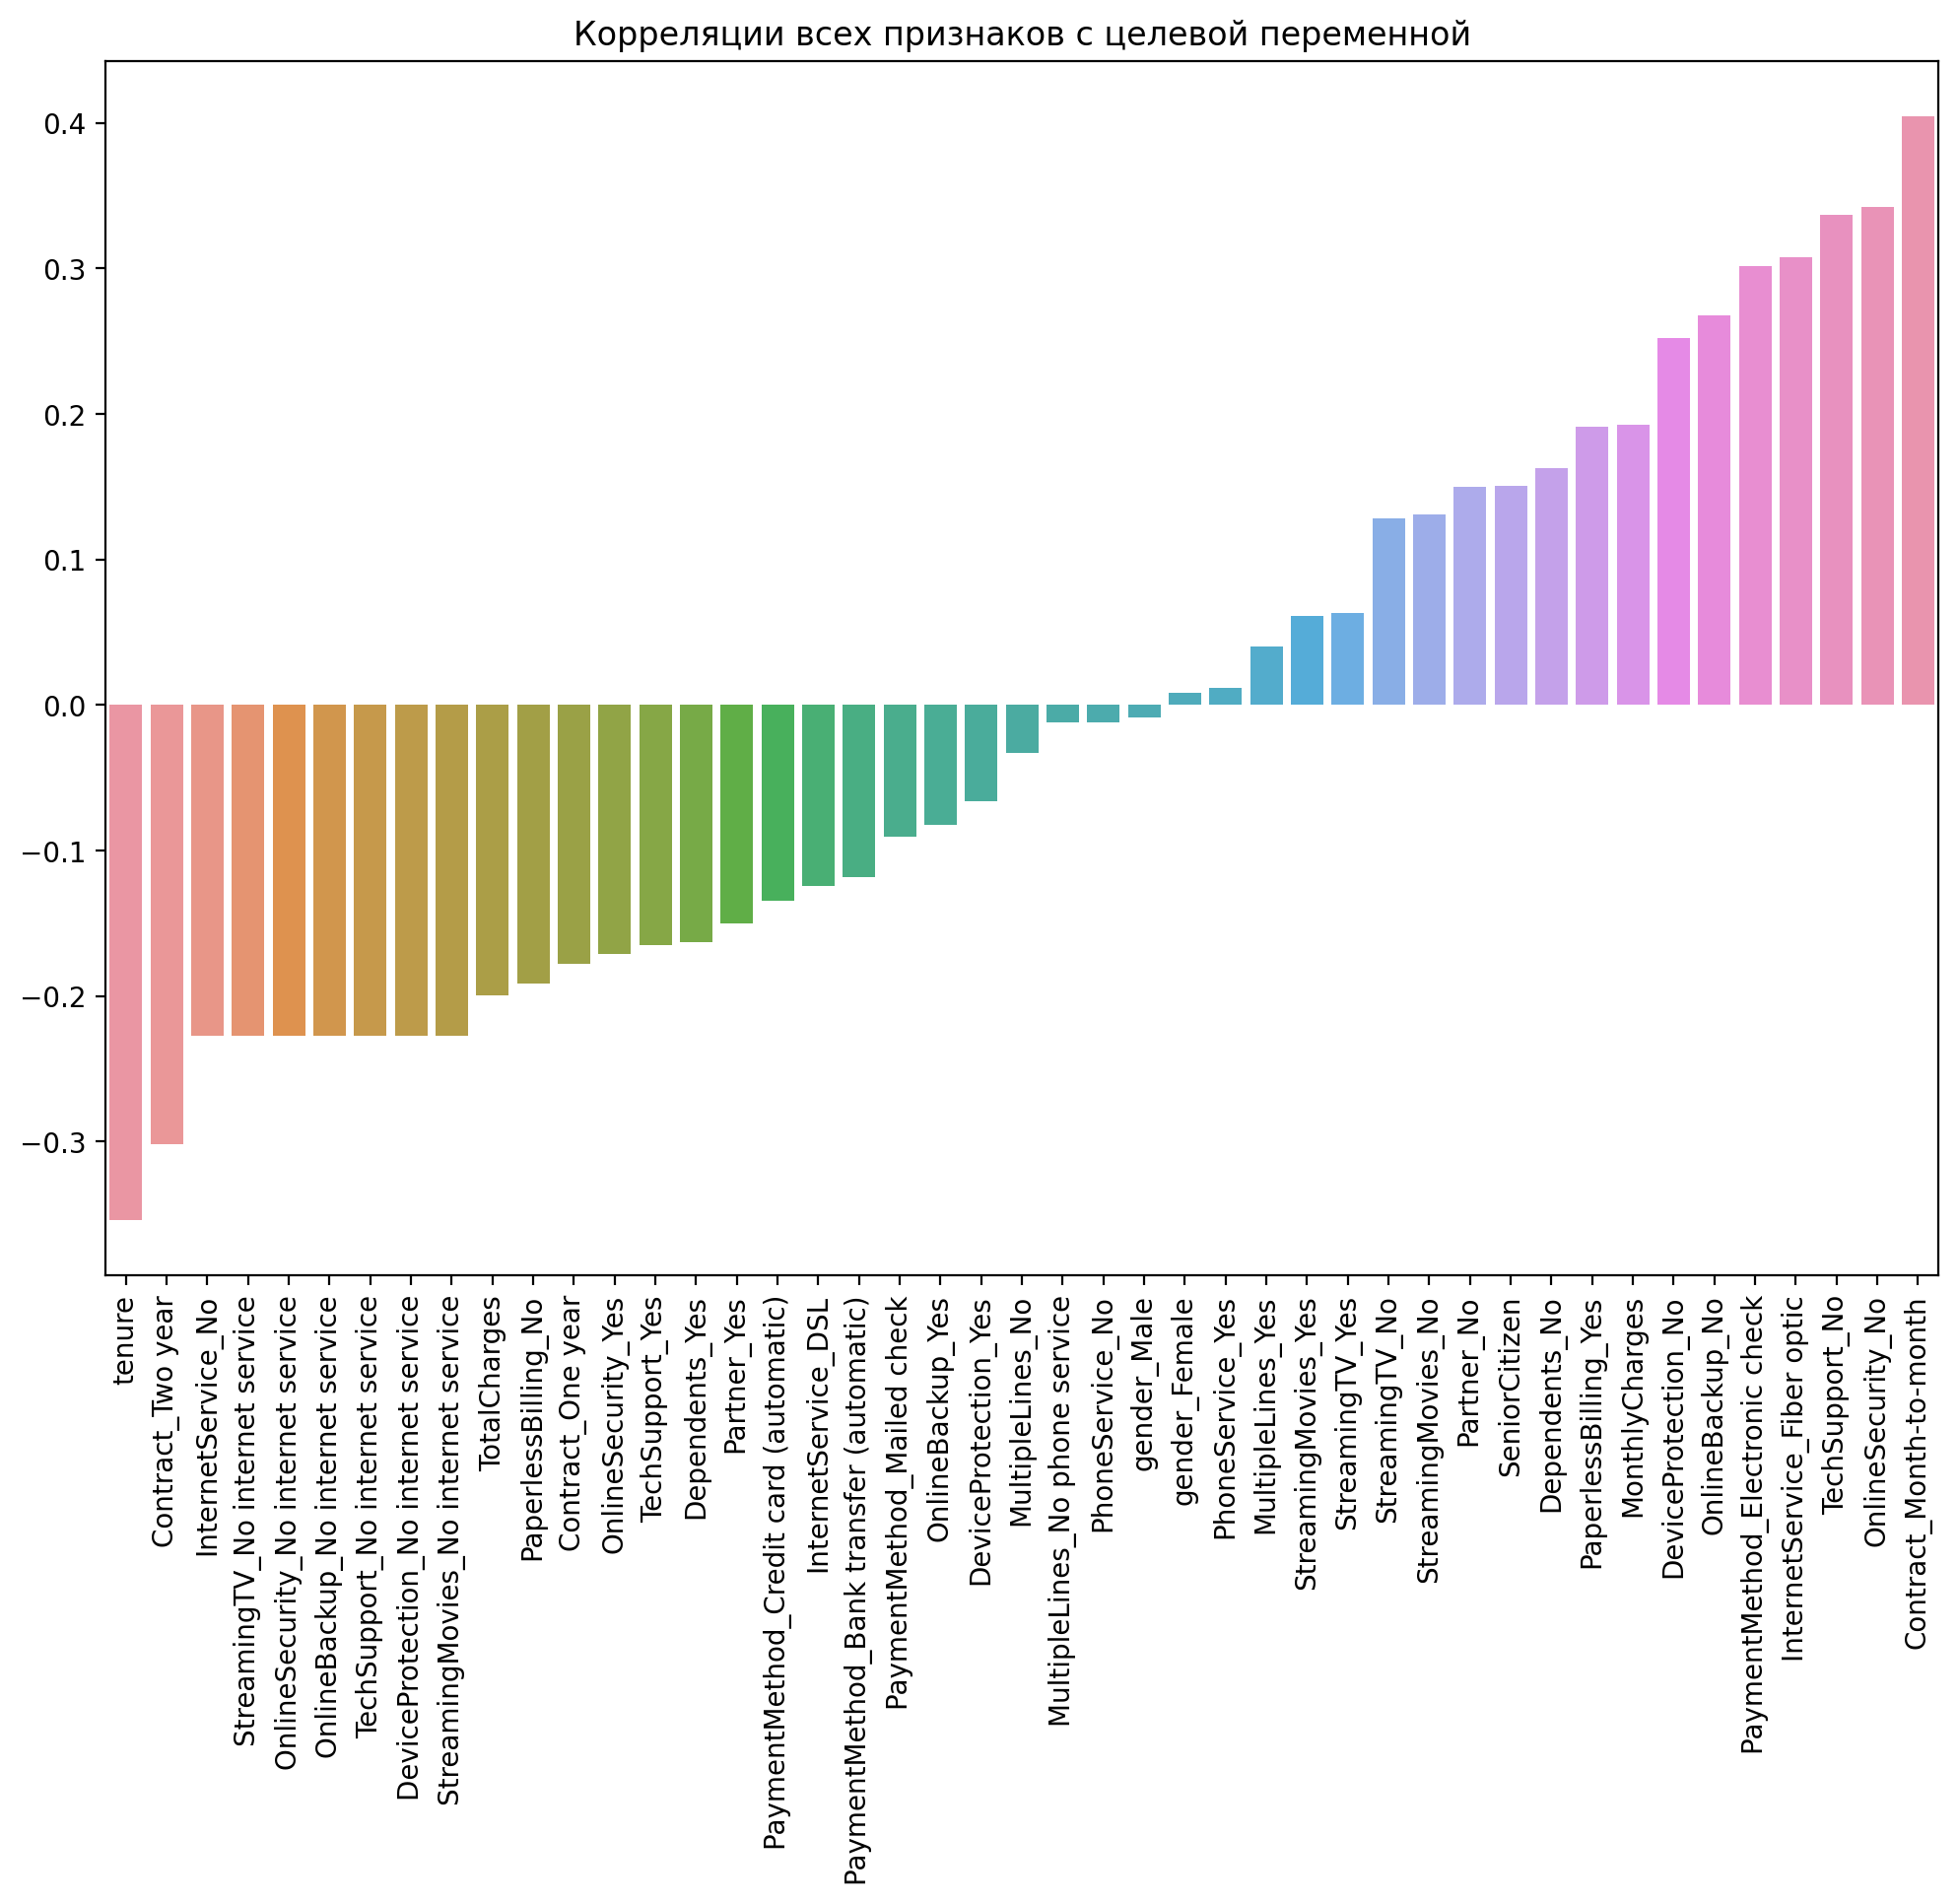

In [13]:
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(x=churn.index, y=churn.values);
plt.xticks(rotation=90);
plt.title('Корреляции всех признаков с целевой переменной');

**Самым слабокоррелированным признаком является продолжительность пользования связью, а самым сильнокоррелированным признаком является контракт на несколько месяцев пользования связью**

## Баланс классов

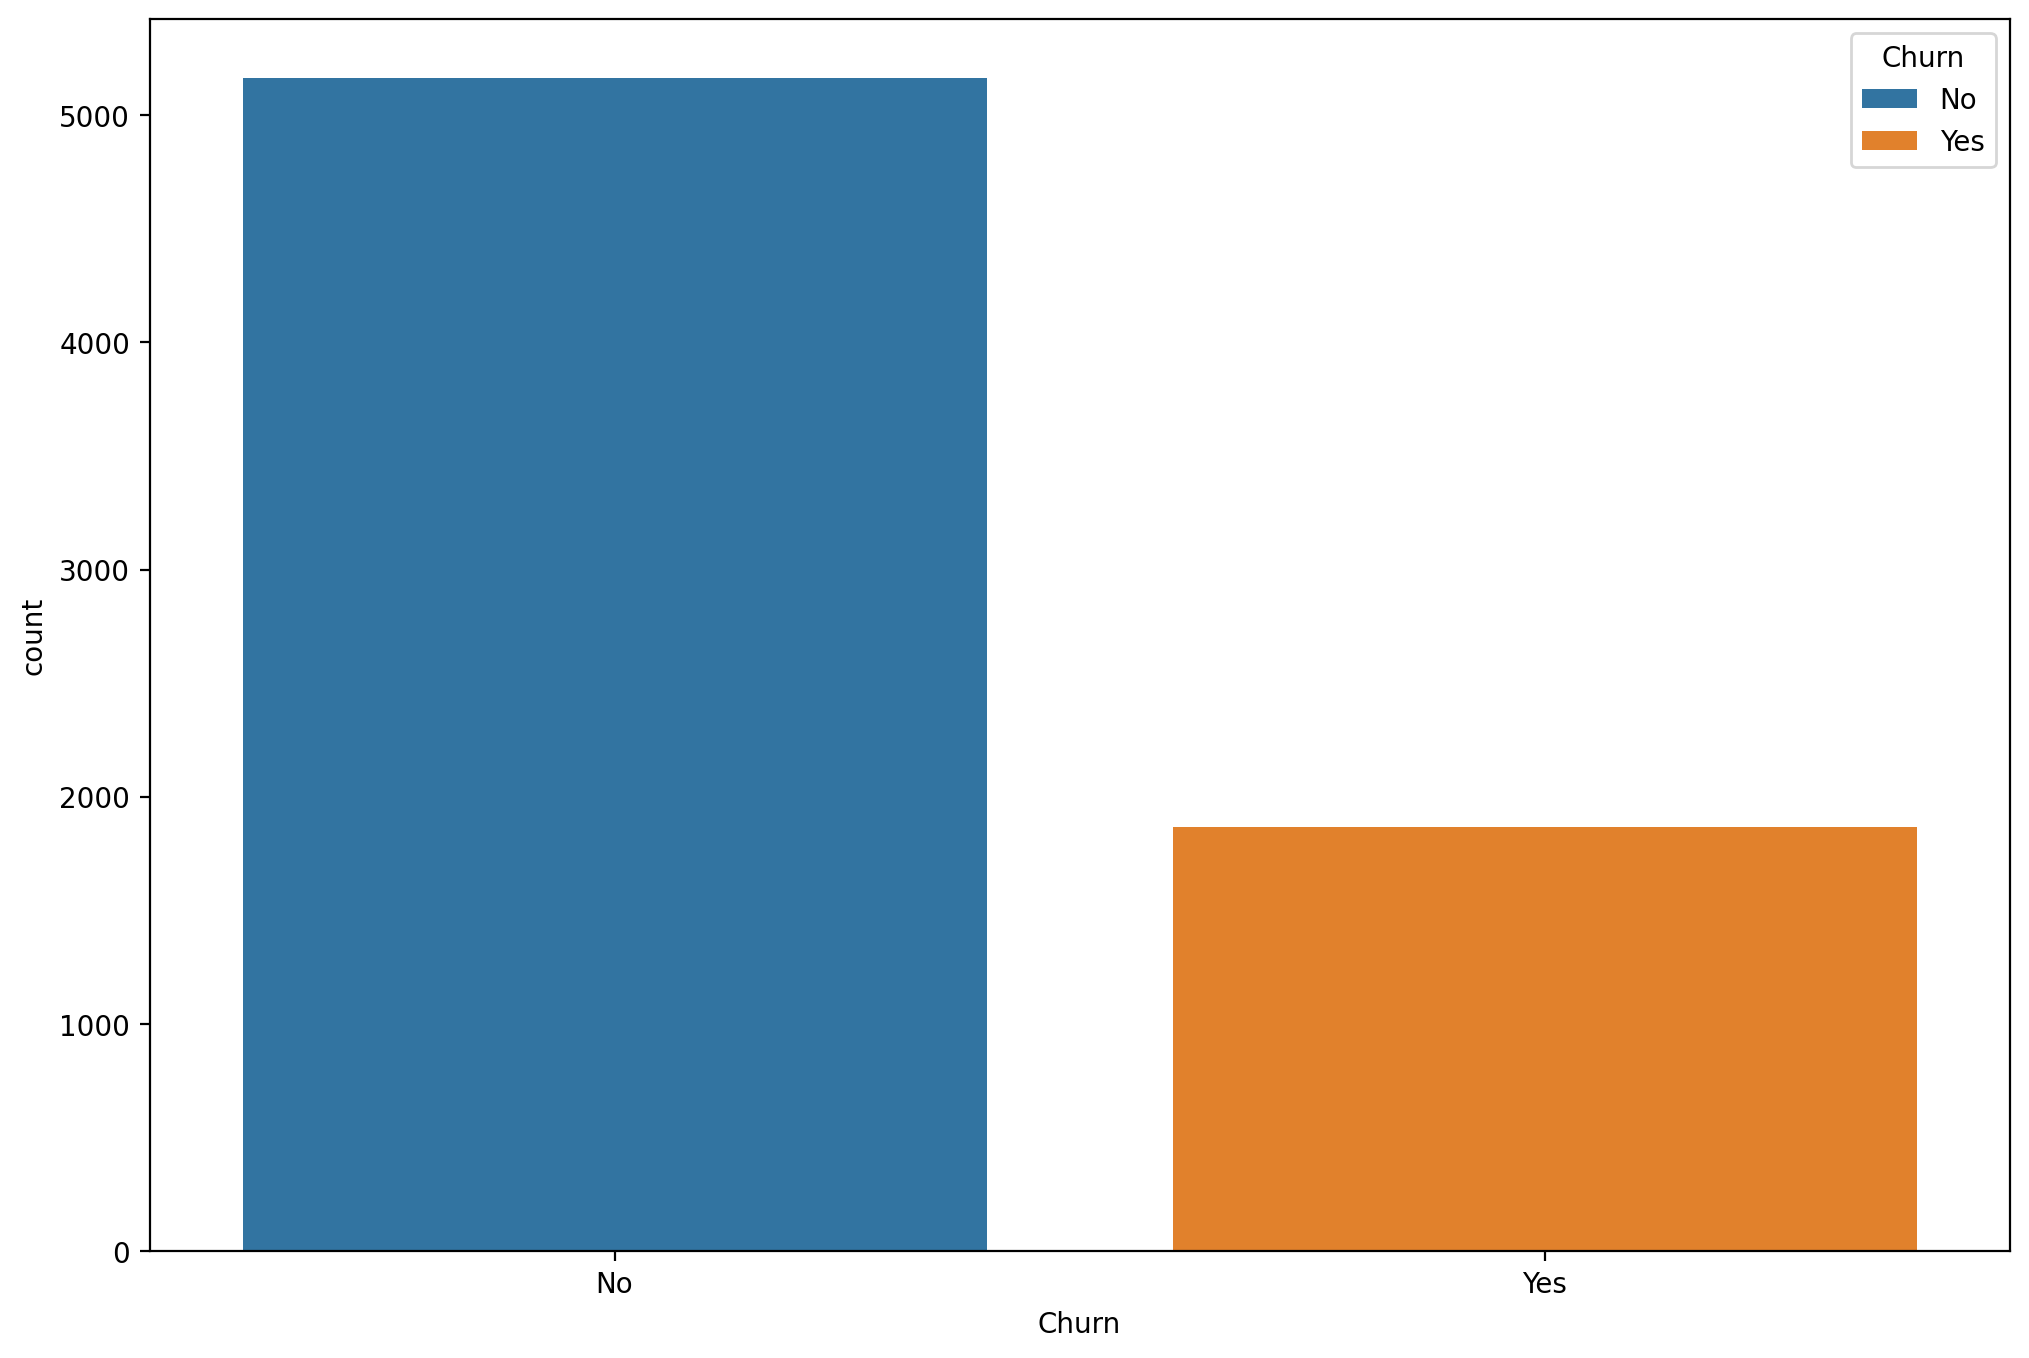

In [14]:
plt.figure(figsize=(12,8), dpi=200)
sns.countplot(data=df, x='Churn', hue='Churn', dodge=False);

## Подсчёт значений для всех категориальных столбцов

In [15]:
categorical_df = df.drop('customerID', axis=1)
categorical_df = categorical_df.select_dtypes(include='object')

In [16]:
categorical_df.head()

gender Partner Dependents PhoneService     MultipleLines InternetService  \
0  Female     Yes         No           No  No phone service             DSL   
1    Male      No         No          Yes                No             DSL   
2    Male      No         No          Yes                No             DSL   
3    Male      No         No           No  No phone service             DSL   
4  Female      No         No          Yes                No     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0              No  Month-to-month              Yes           Electronic check   
1              No        One year               No               Mailed check   
2              No  Month-to-month              Yes               Mailed check   
3              No        One year               No  Bank transfer (automatic)   
4              No  Month-to-month              Yes           Electronic check   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [17]:
def plot_countplot(col, hue, palette1='icefire', palette2='rocket', fig_size=(12,6)):
    print(df[col].value_counts().to_dict())
    fig, ax = plt.subplots(2, 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts(ascending=True).index, palette=palette1, ax=ax[0])
    sns.countplot(data=df, x=col, hue=hue, order=df[col].value_counts(ascending=True).index, palette=palette2, ax=ax[1])
    plt.tight_layout()
    plt.legend(loc=(1.05, 0.5), title='Churn')
    plt.show()

{'Male': 3549, 'Female': 3483}


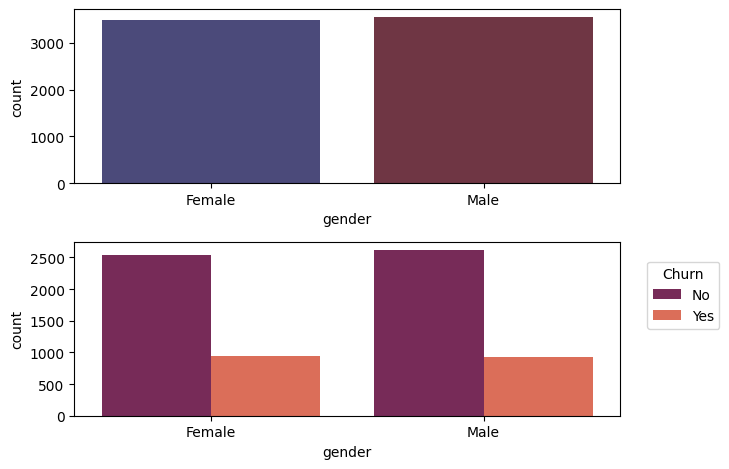

{'No': 3639, 'Yes': 3393}


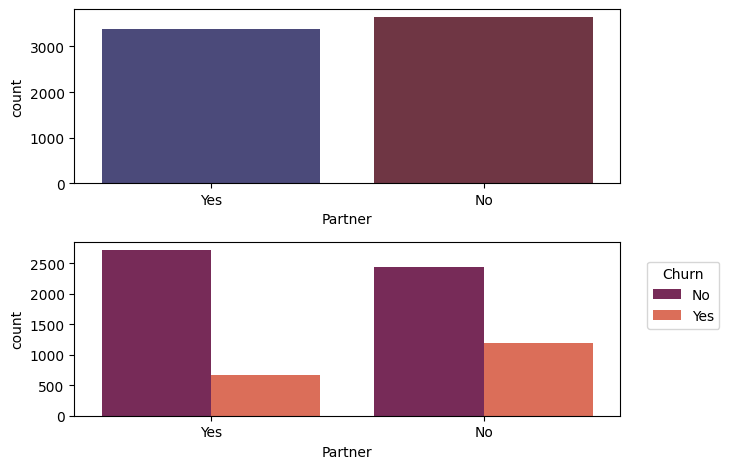

{'No': 4933, 'Yes': 2099}


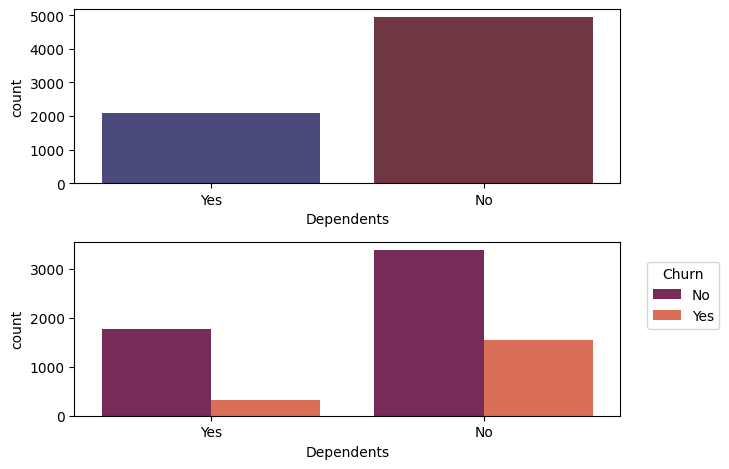

{'Yes': 6352, 'No': 680}


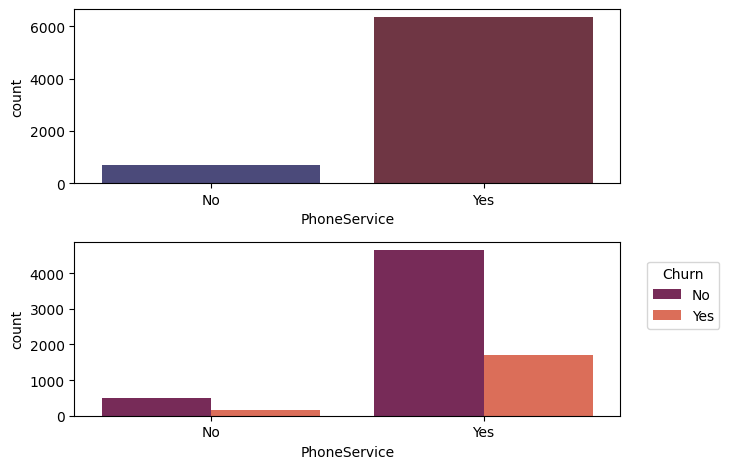

{'No': 3385, 'Yes': 2967, 'No phone service': 680}


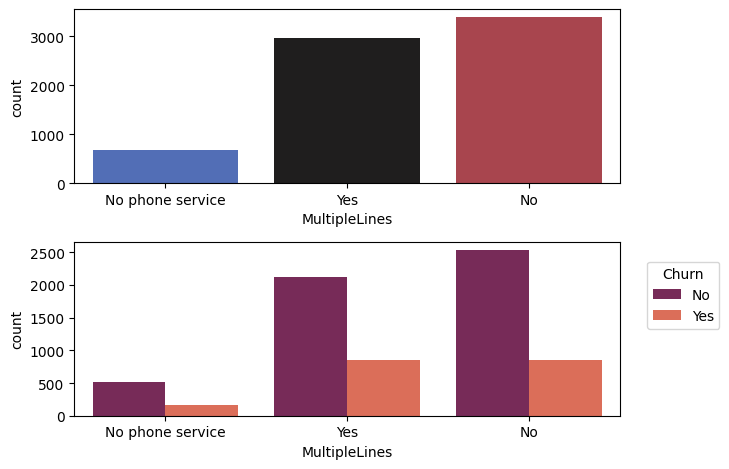

{'Fiber optic': 3096, 'DSL': 2416, 'No': 1520}


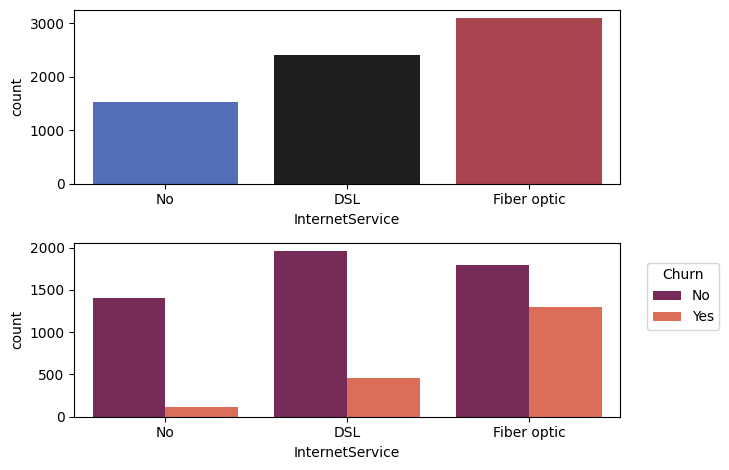

{'No': 3497, 'Yes': 2015, 'No internet service': 1520}


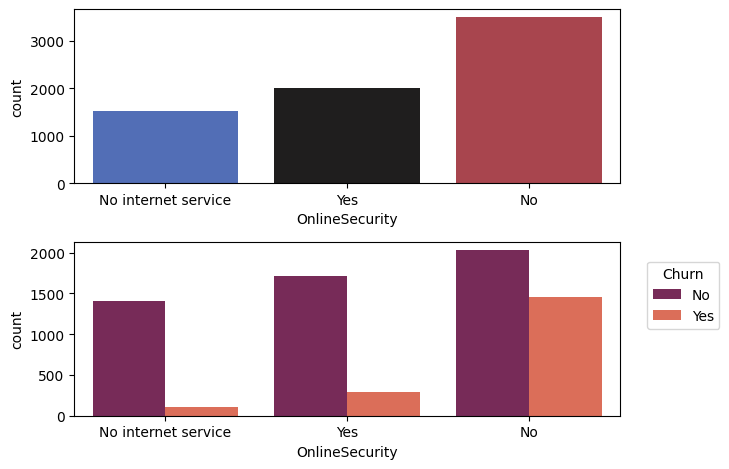

{'No': 3087, 'Yes': 2425, 'No internet service': 1520}


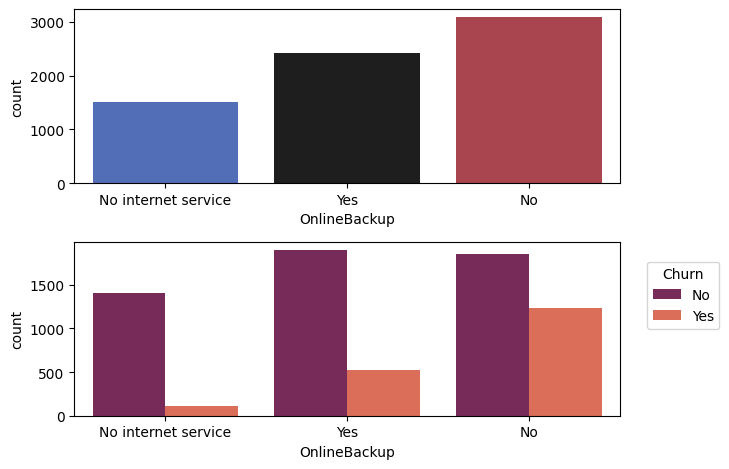

{'No': 3094, 'Yes': 2418, 'No internet service': 1520}


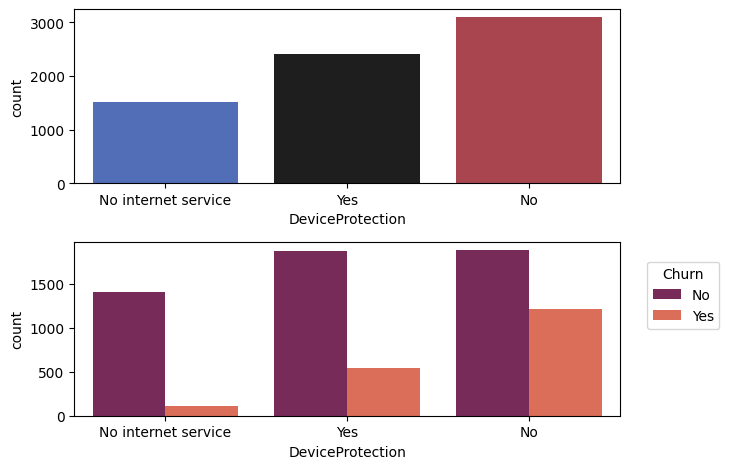

{'No': 3472, 'Yes': 2040, 'No internet service': 1520}


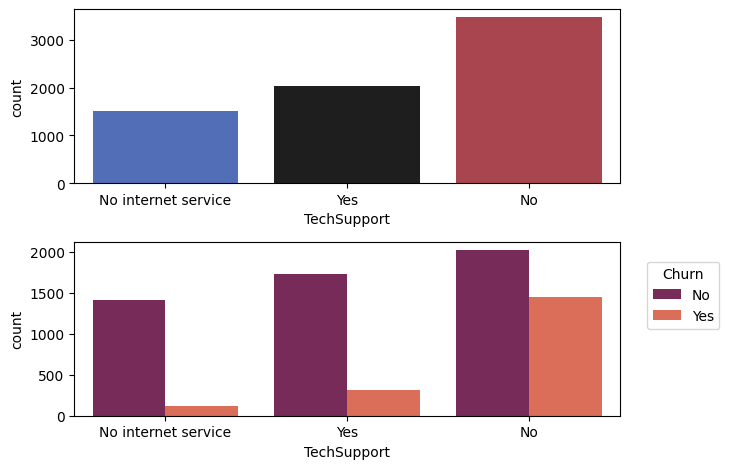

{'No': 2809, 'Yes': 2703, 'No internet service': 1520}


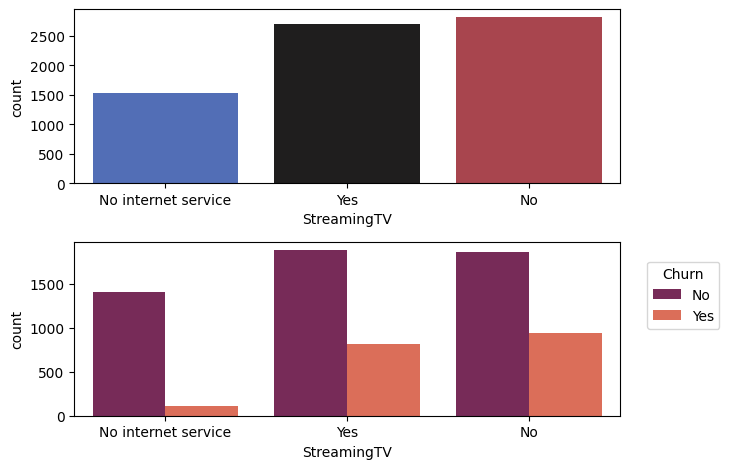

{'No': 2781, 'Yes': 2731, 'No internet service': 1520}


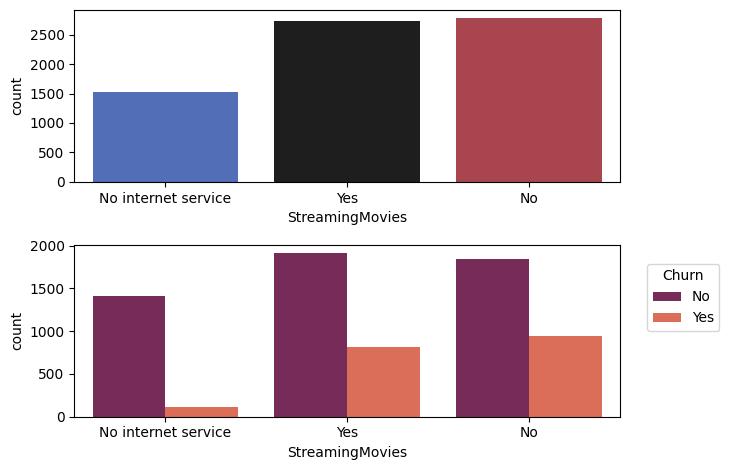

{'Month-to-month': 3875, 'Two year': 1685, 'One year': 1472}


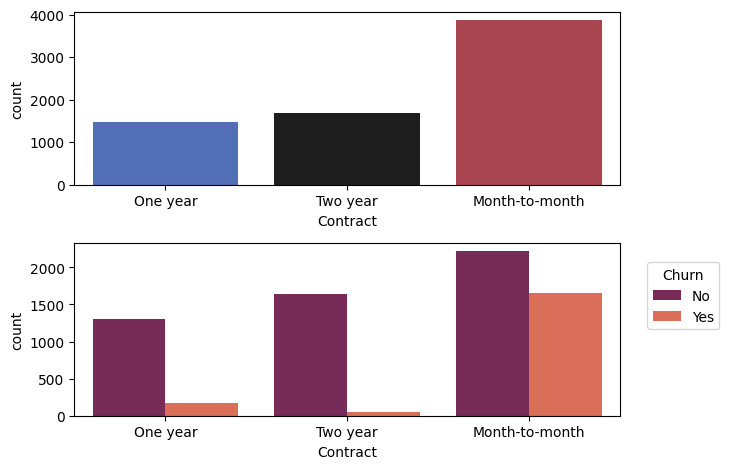

{'Yes': 4168, 'No': 2864}


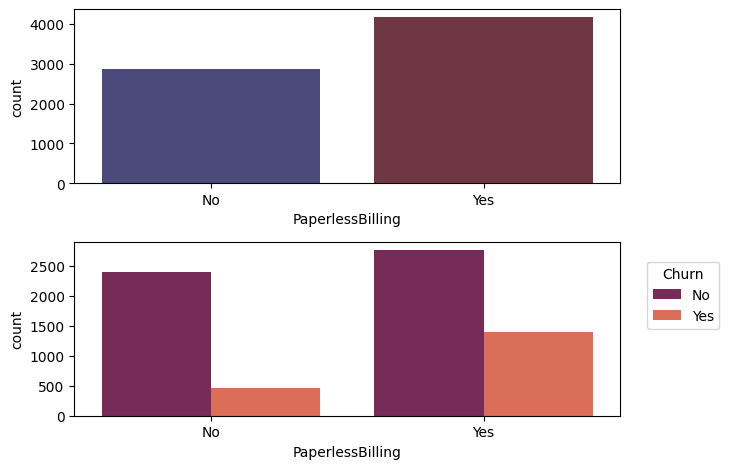

In [18]:
for col in categorical_df.columns:
    if col != 'Churn' and col != 'PaymentMethod':
        plot_countplot(col, 'Churn')

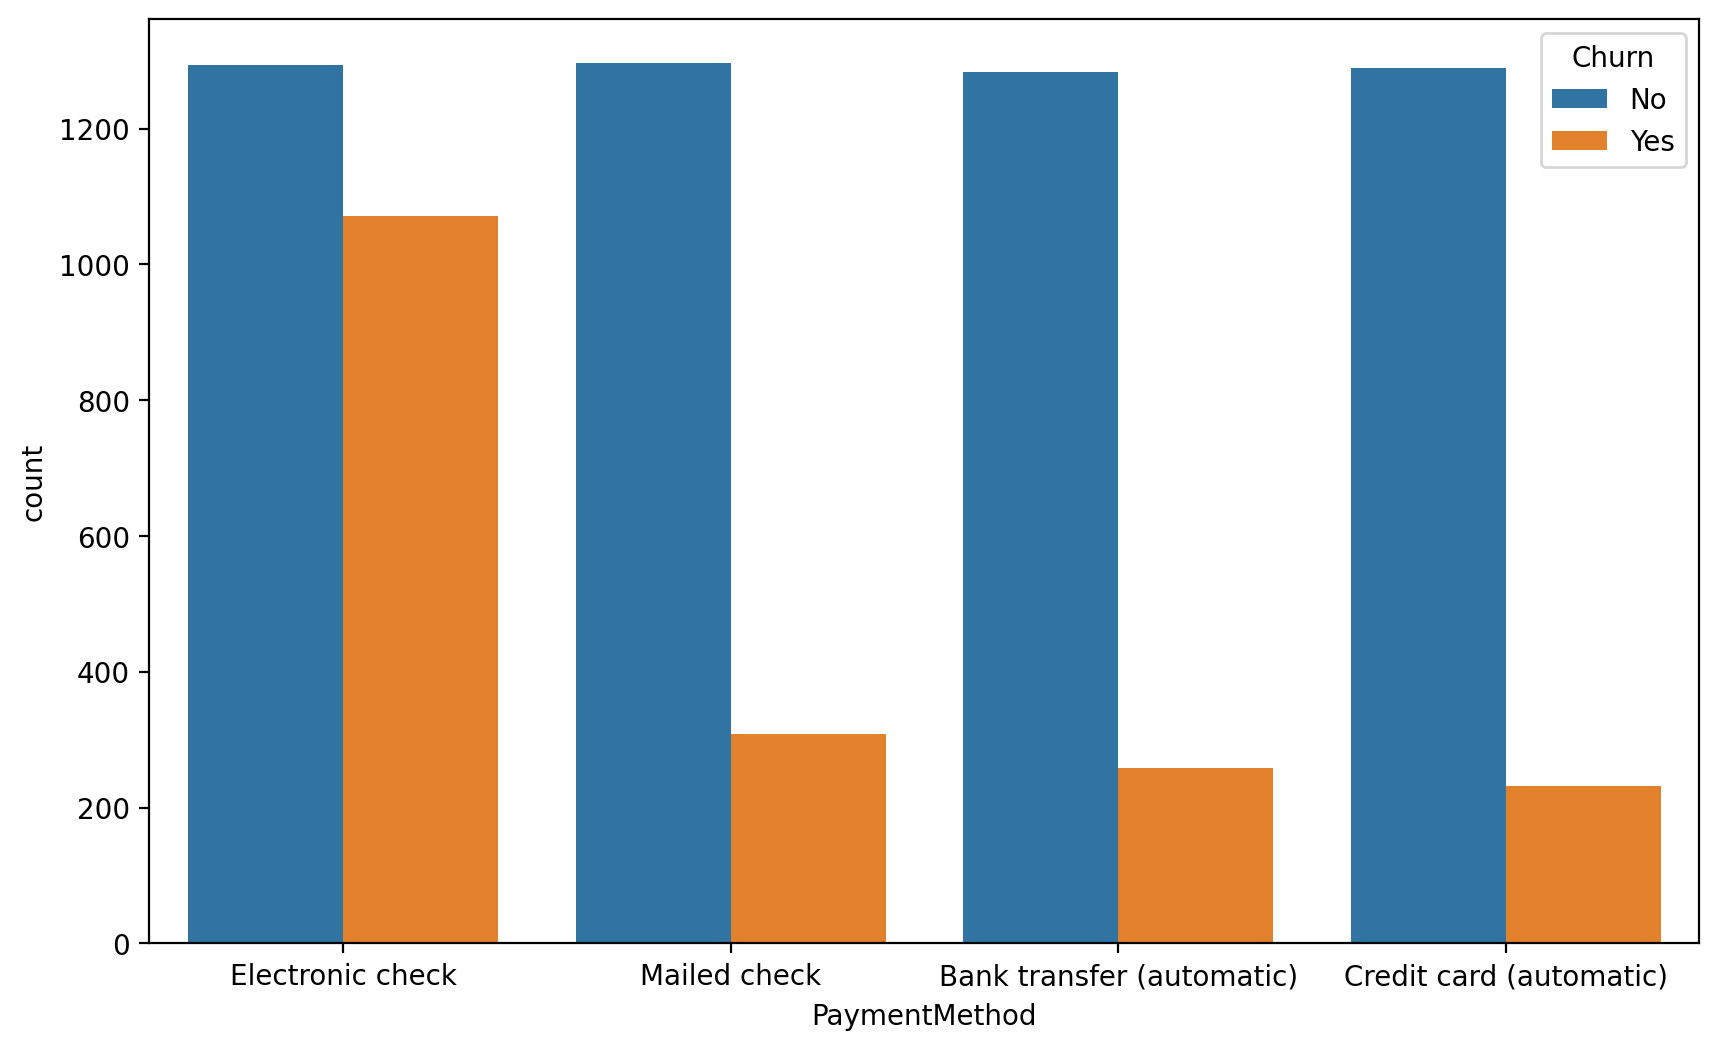

In [19]:
plt.figure(figsize=(10,6),dpi=200)
sns.countplot(data=df, x='PaymentMethod', hue='Churn');

---
---

# Анализ оттока

**В данном разделе мы выполним сегментацию абонентов на основе колонки tenure, создавая "когорты" - группы пользователей с одинаковой длительностью пользования, и выполняя сравнение данных между различными когортами.**

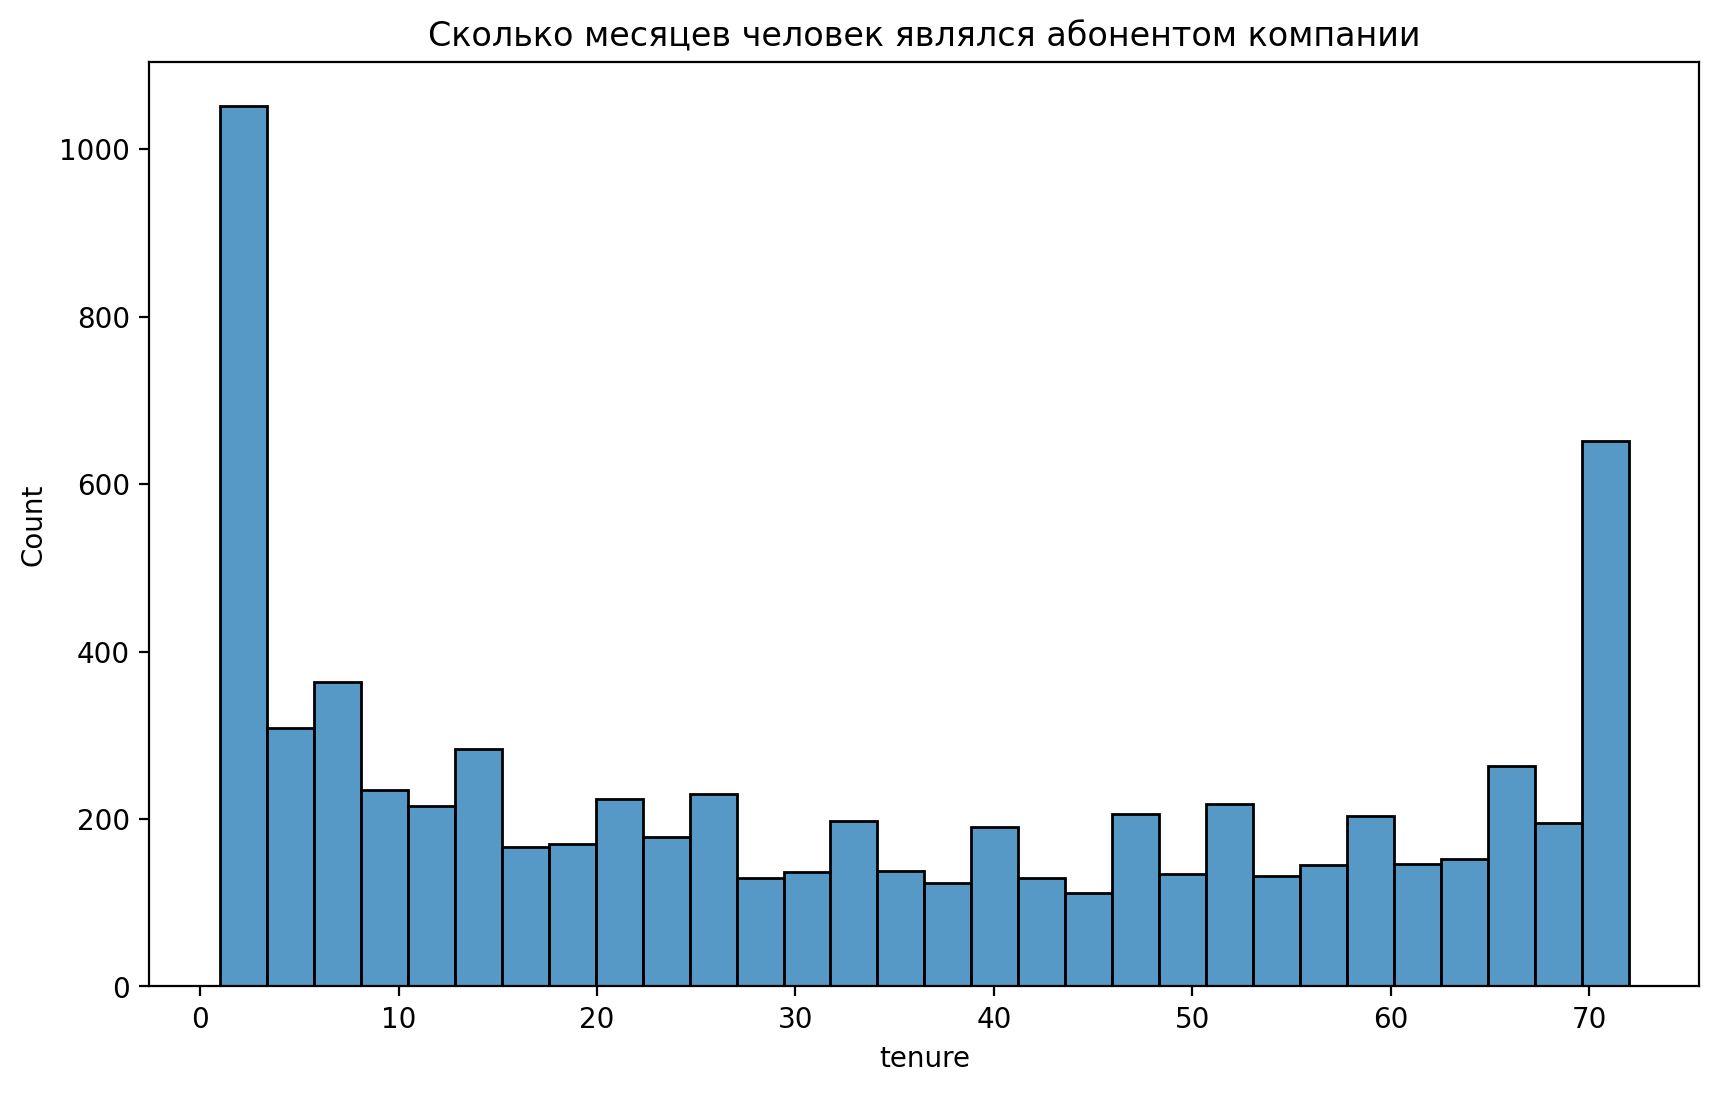

In [20]:
plt.figure(figsize=(10,6),dpi=200)
sns.histplot(data=df, x='tenure', bins=30)
plt.title('Сколько месяцев человек являлся абонентом компании');

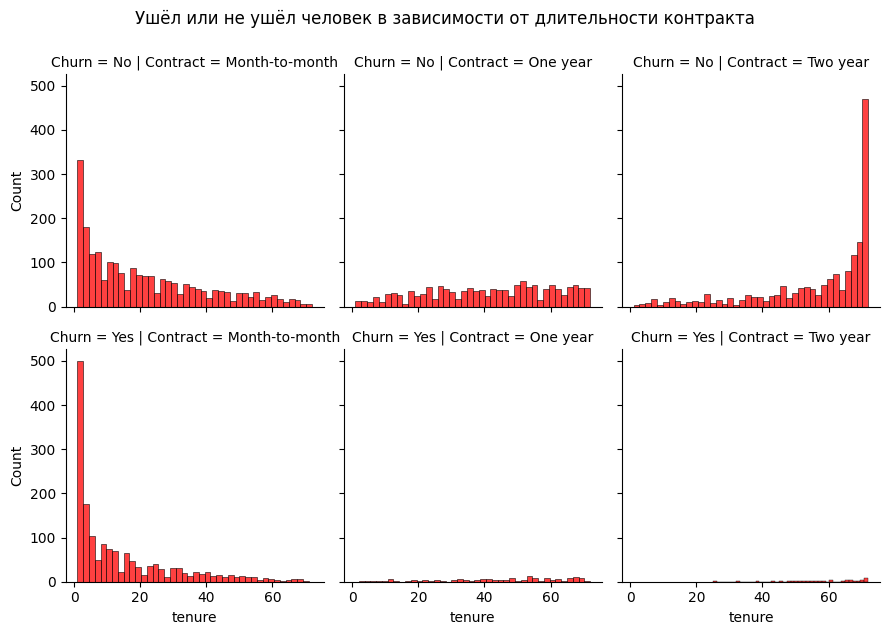

In [21]:
g = sns.FacetGrid(data=df, col='Contract', row='Churn')
g = g.map(sns.histplot, 'tenure', bins=40, color='r')
g.fig.suptitle('Ушёл или не ушёл человек в зависимости от длительности контракта', x=0.5, y=1.05);

In [31]:
# Формируем когорты ушедших абонентов по месяцам
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
cogorts = df.groupby('tenure')['Churn'].apply(lambda x: (sum(x) / len(x)) * 100)

In [32]:
def senior_sitizen(x):
    if x == 0:
        return '0'
    else:
        return '1'

In [33]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: senior_sitizen(x))

In [23]:
cogorts.to_frame()

Churn
tenure           
1       61.990212
2       51.680672
3       47.000000
4       47.159091
5       48.120301
...           ...
68       9.000000
69       8.421053
70       9.243697
71       3.529412
72       1.657459

[72 rows x 1 columns]

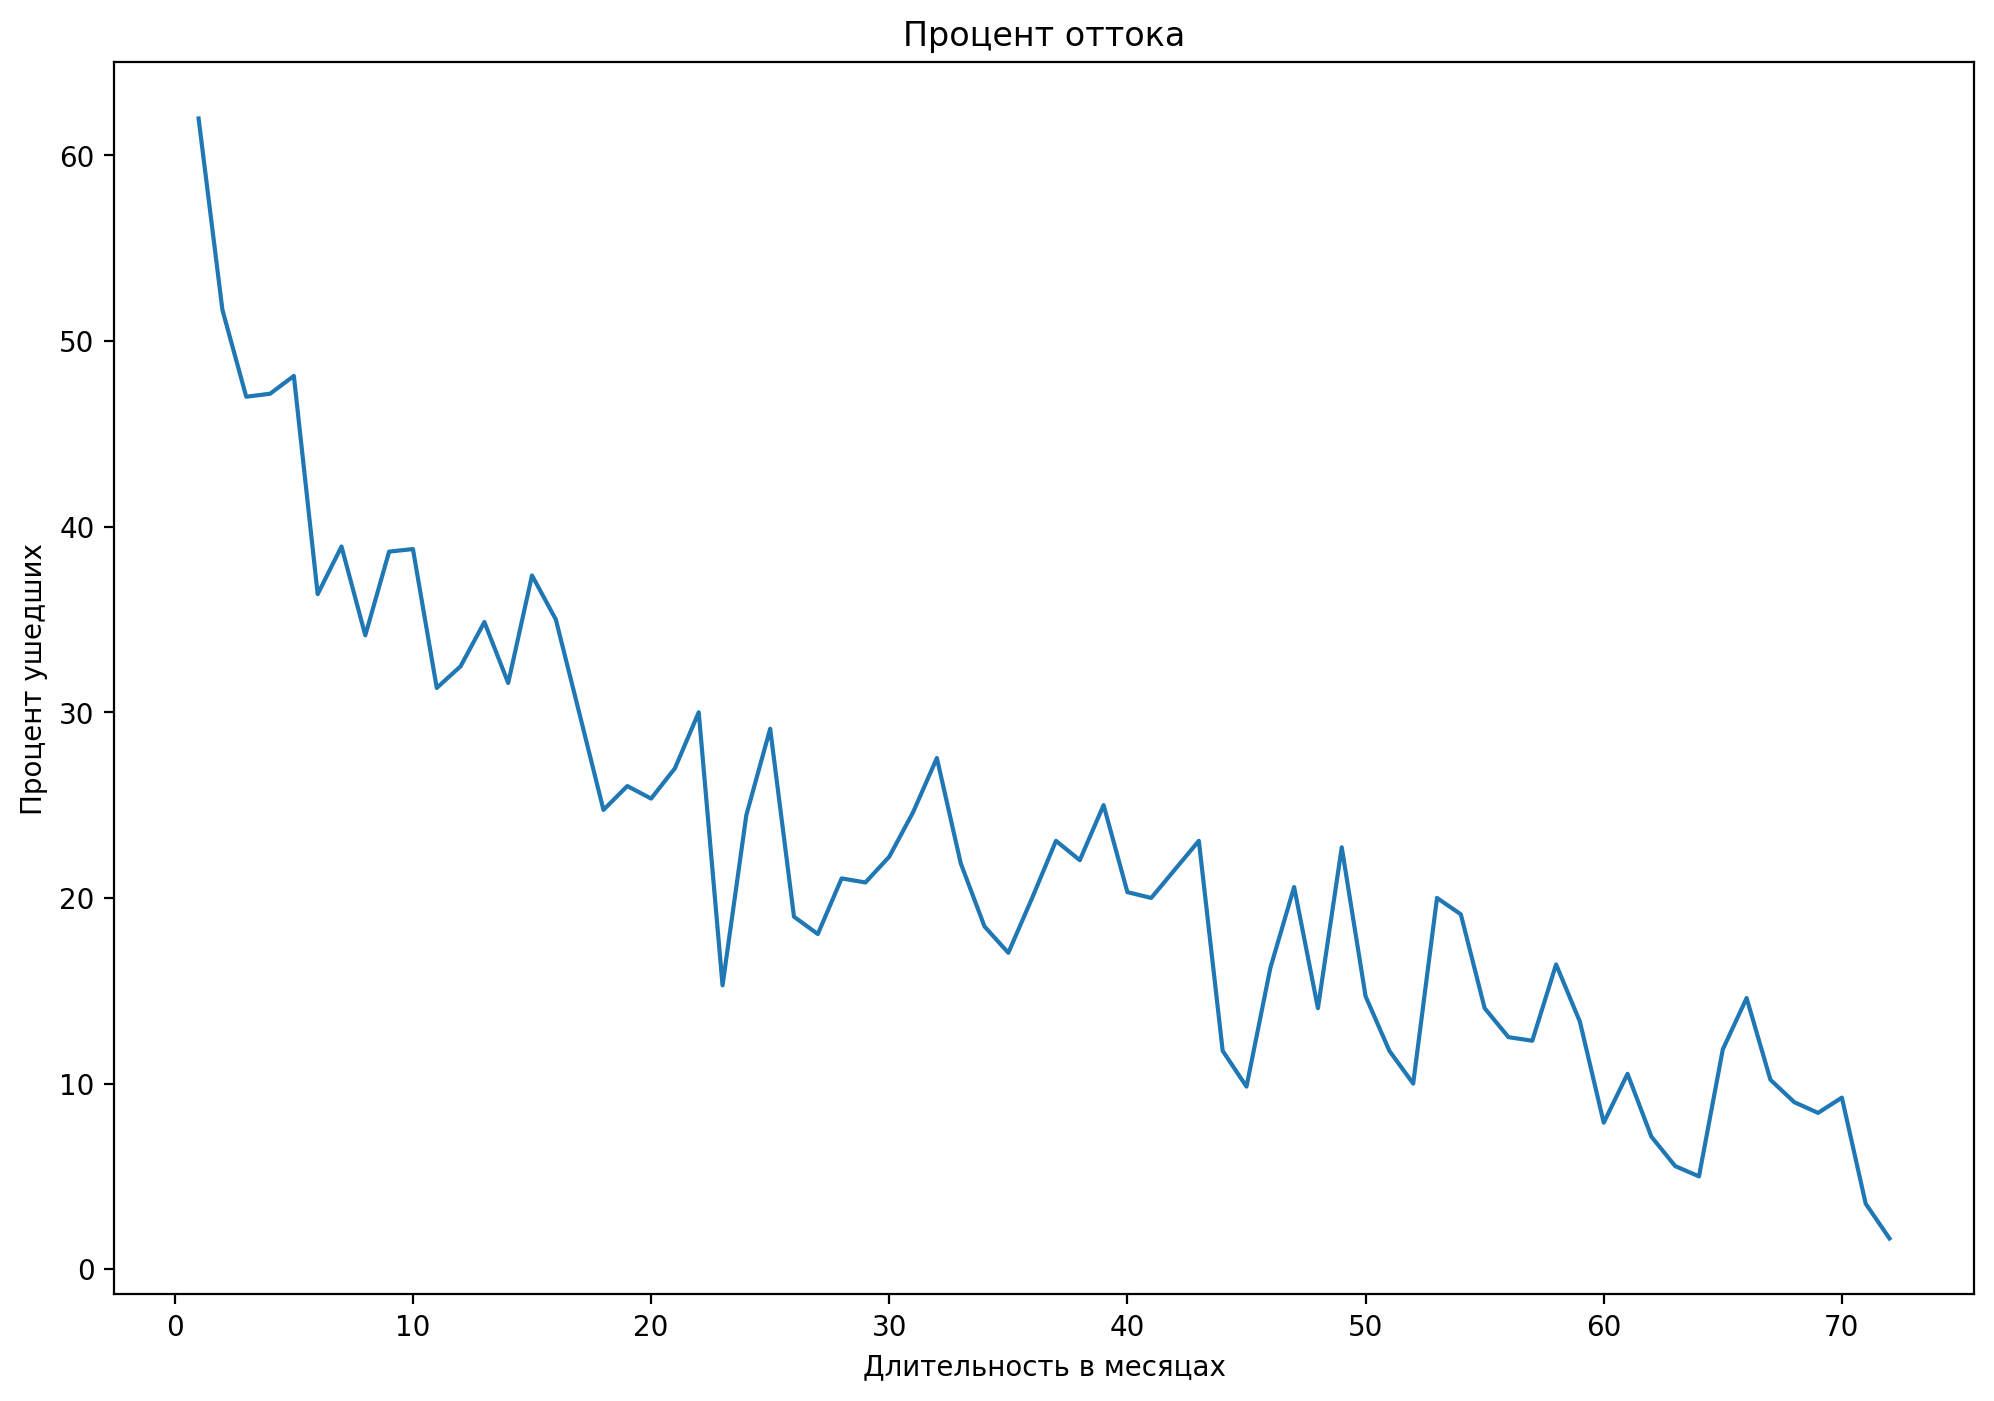

In [24]:
plt.figure(figsize=(12,8),dpi=200)
cogorts.plot(xlabel='Длительность в месяцах', ylabel='Процент ушедших');
plt.title('Процент оттока');

## Построение более обширных когорт

In [34]:
def new_cogorts(x):
    if 0 <= x <= 12:
        return '0-12 Months'
    elif 12 < x <= 24:
        return '12-24 Months'
    elif 24 < x <= 48:
        return '24-48 Months'
    else:
        return 'Over 48 Months'

In [35]:
df['Tenure Cohort'] = df['tenure'].apply(lambda x: new_cogorts(x))

In [6]:
df.head(10)[['tenure', 'Tenure Cohort']]

tenure   Tenure Cohort
0       1     0-12 Months
1      34    24-48 Months
2       2     0-12 Months
3      45    24-48 Months
4       2     0-12 Months
5       8     0-12 Months
6      22    12-24 Months
7      10     0-12 Months
8      28    24-48 Months
9      62  Over 48 Months

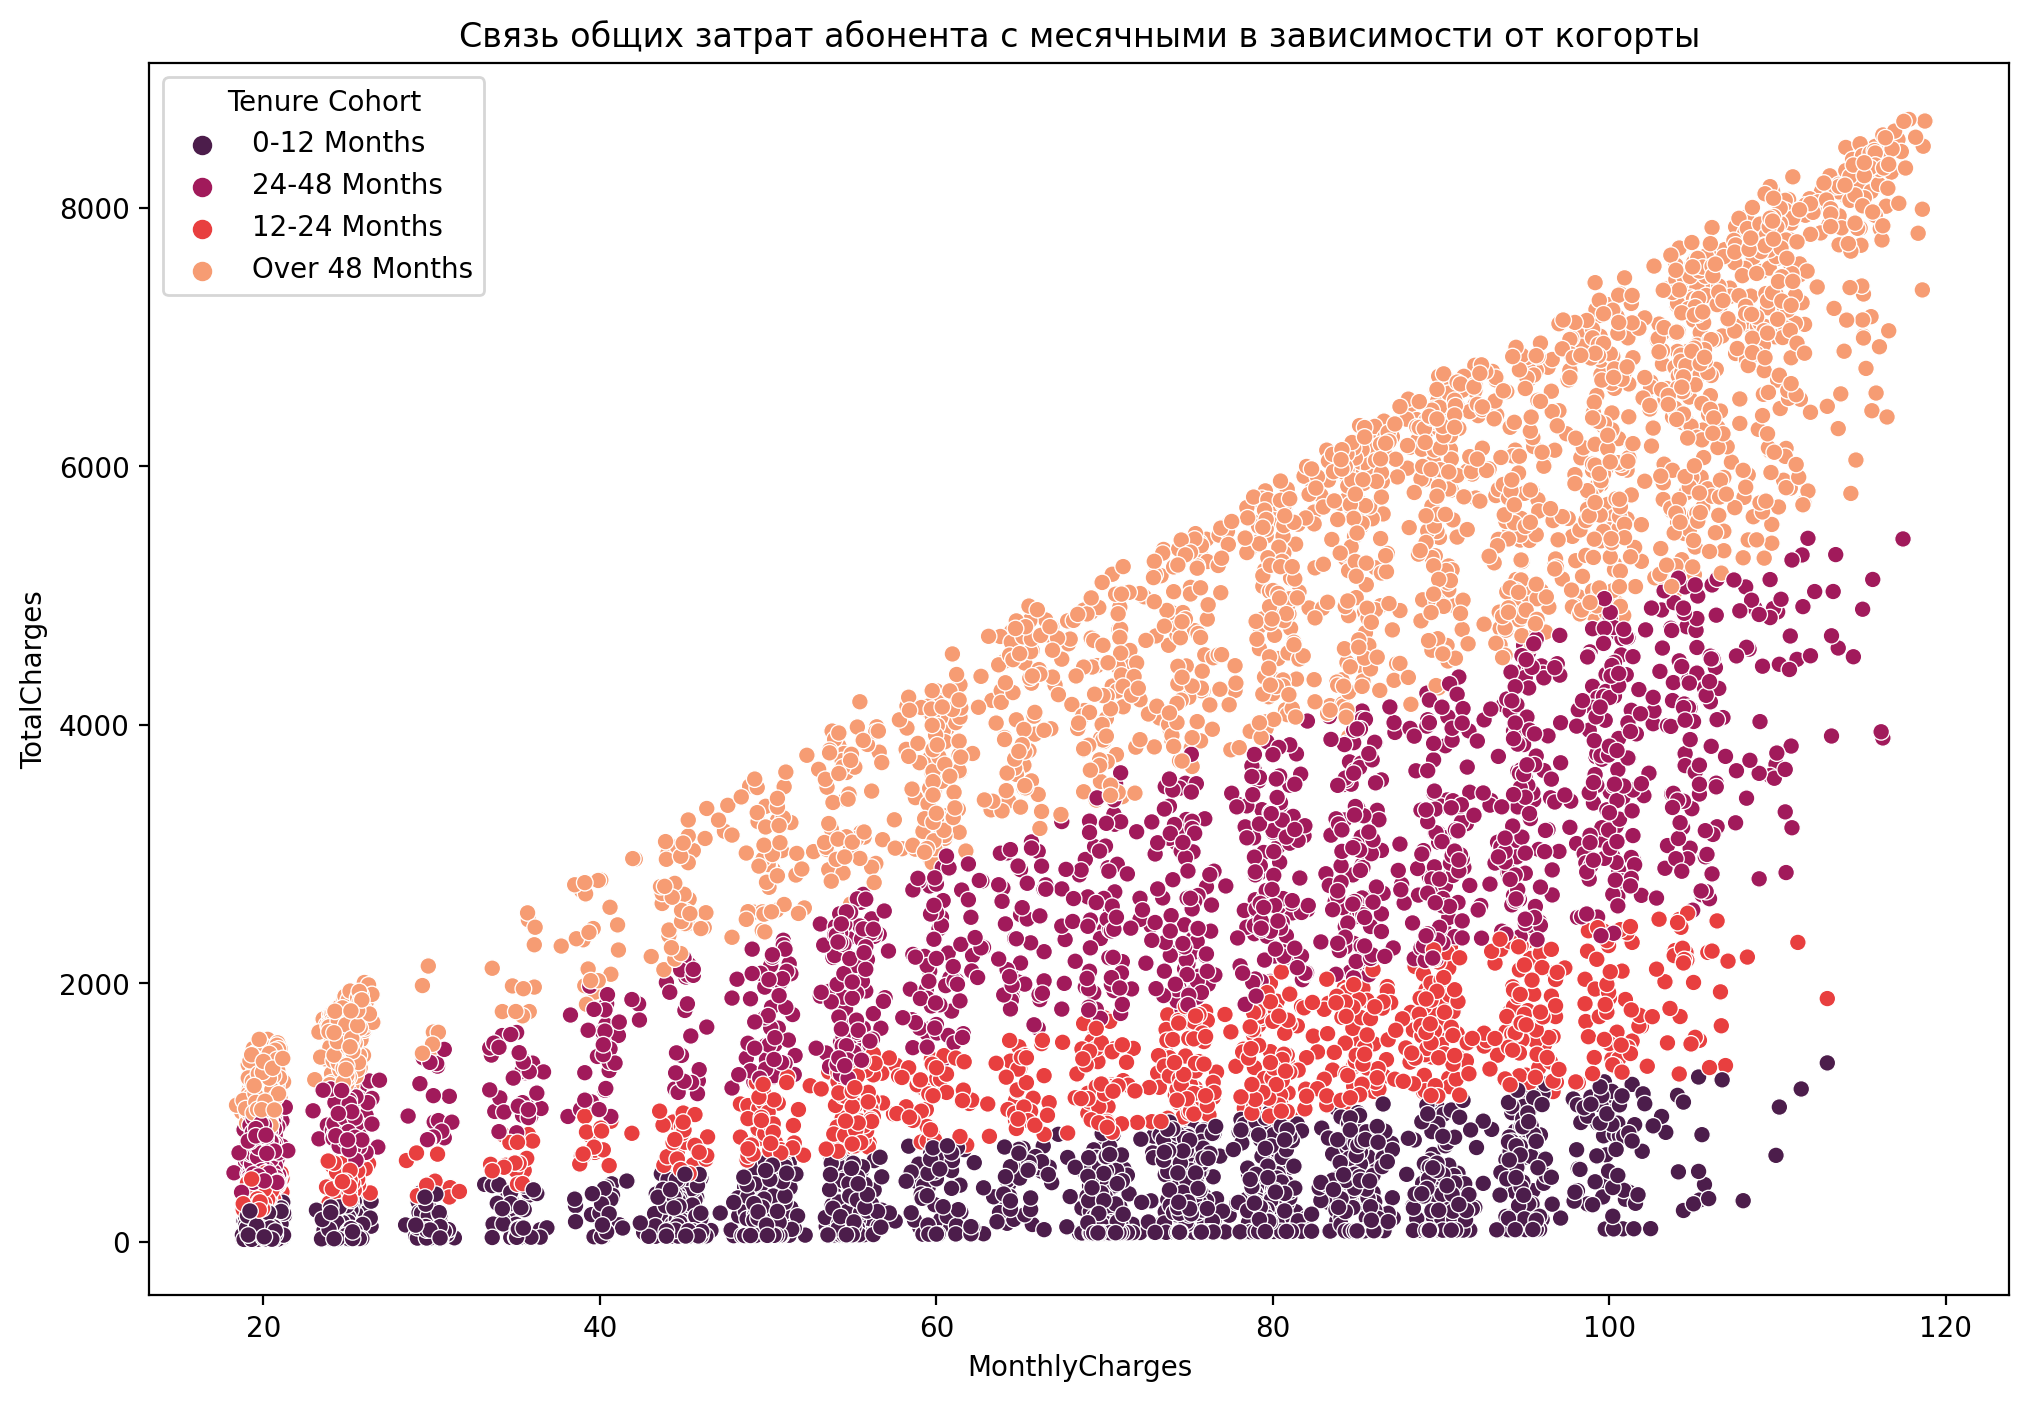

In [28]:
plt.figure(figsize=(12,8),dpi=200)
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Tenure Cohort', palette='rocket');
plt.title('Связь общих затрат абонента с месячными в зависимости от когорты');

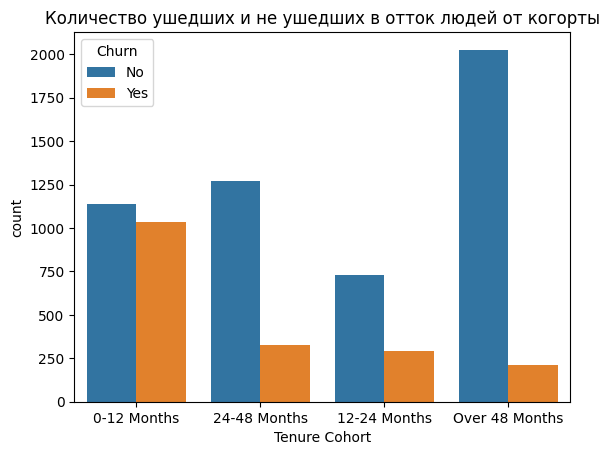

In [29]:
sns.countplot(data=df, x='Tenure Cohort', hue='Churn')
plt.legend(title='Churn', labels=['No', 'Yes']);
plt.title('Количество ушедших и не ушедших в отток людей от когорты');

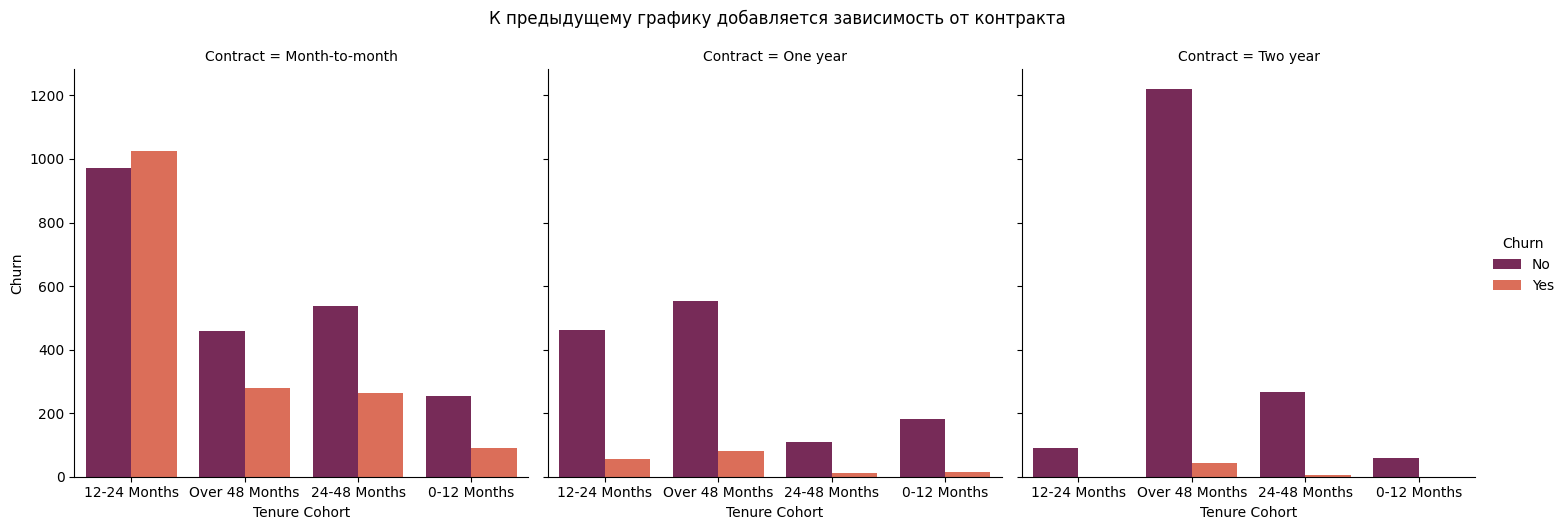

In [30]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)
    
g = sns.FacetGrid(data=df, col='Contract', height=5)
g = g.map(countplot, 'Tenure Cohort', 'Churn', palette='rocket')
g.add_legend(title='Churn', labels=['No', 'Yes']);
g.fig.suptitle('К предыдущему графику добавляется зависимость от контракта', x=0.5, y=1.05);

------
------

# Построение ML моделей

In [36]:
new_df = df.drop('customerID', axis=1)
dummy_df = pd.get_dummies(new_df, drop_first=True)

In [37]:
X = dummy_df.drop('Churn', axis=1)
y = dummy_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [38]:
X_categorical_train = X_train.select_dtypes(include='uint8')
X_num_train = X_train.select_dtypes(exclude='uint8')

X_categorical_test = X_test.select_dtypes(include='uint8')
X_num_test = X_test.select_dtypes(exclude='uint8')

# Масштабирование
scaler = StandardScaler()
X_scaled_num_train = scaler.fit_transform(X_num_train)
X_scaled_num_test = scaler.transform(X_num_test)

# Создание датафреймов с численными колонками
X_scaled_num_train = pd.DataFrame(X_scaled_num_train, columns=X_num_train.columns, index=X_num_train.index)
X_scaled_num_test = pd.DataFrame(X_scaled_num_test, columns=X_num_test.columns, index=X_num_test.index)

X_train = pd.concat([X_scaled_num_train, X_categorical_train], axis=1)
X_test = pd.concat([X_scaled_num_test, X_categorical_test], axis=1)

In [65]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [39]:
def get_params_and_predict_model(model, X_test, y_test):
    print(model.best_estimator_.get_params())
    preds = model.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    print(classification_report(y_test, preds))
    RocCurveDisplay.from_estimator(model, X_test, y_test)

## Логистическая регрессия

In [35]:
log_model = LogisticRegression(solver='saga', multi_class='ovr')
C = [0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2', 'elasticnet']
class_weight = ['balanced', None]
l1_ratio = [0.01, 0.1, 0.2, 0.5, 0.9, 1]

In [36]:
param_grid = {'C': C, 'penalty': penalty, 'class_weight': class_weight, 
              'l1_ratio': l1_ratio}

In [37]:
log_grid_model = GridSearchCV(log_model, param_grid=param_grid)
log_grid_model.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(multi_class='ovr', solver='saga'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.9, 1],
                         'penalty': ['l1', 'l2', 'elasticnet']})

{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.01, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       557
           1       0.60      0.53      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



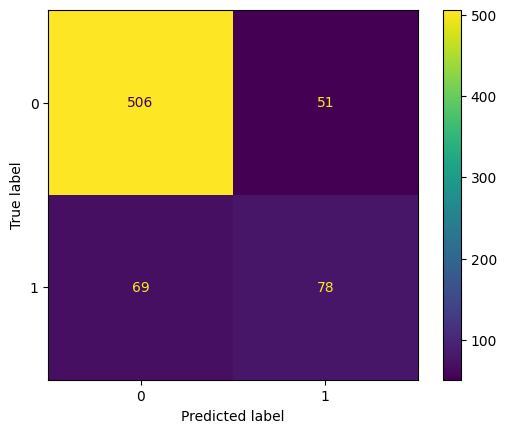

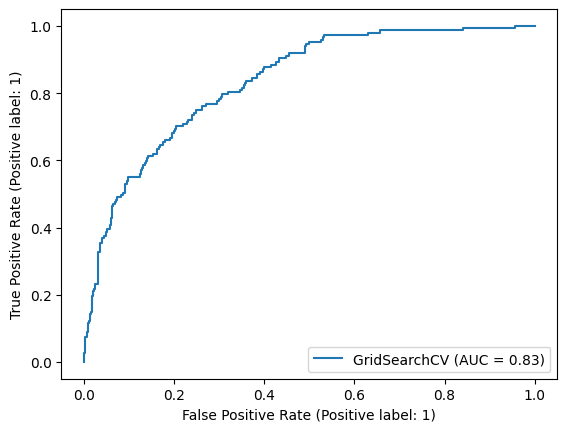

In [38]:
get_params_and_predict_model(log_grid_model, X_test, y_test)

## Метод ближайших соседей с пайплайном

In [39]:
knn_model = KNeighborsClassifier()
scaler = StandardScaler()

In [40]:
prep = [('scaler', scaler), ('knn_model', knn_model)]
pipe = Pipeline(prep)

In [41]:
n_neighbors = [i for i in range(16)]
grid_params = {'knn_model__n_neighbors': n_neighbors}

In [42]:
grid_model = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring='accuracy')
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_model', KNeighborsClassifier())]),
             param_grid={'knn_model__n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                    9, 10, 11, 12, 13, 14,
                                                    15]},
             scoring='accuracy')

{'memory': None, 'steps': [('scaler', StandardScaler()), ('knn_model', KNeighborsClassifier(n_neighbors=14))], 'verbose': False, 'scaler': StandardScaler(), 'knn_model': KNeighborsClassifier(n_neighbors=14), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'knn_model__algorithm': 'auto', 'knn_model__leaf_size': 30, 'knn_model__metric': 'minkowski', 'knn_model__metric_params': None, 'knn_model__n_jobs': None, 'knn_model__n_neighbors': 14, 'knn_model__p': 2, 'knn_model__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       557
           1       0.53      0.48      0.51       147

    accuracy                           0.80       704
   macro avg       0.70      0.69      0.69       704
weighted avg       0.80      0.80      0.80       704



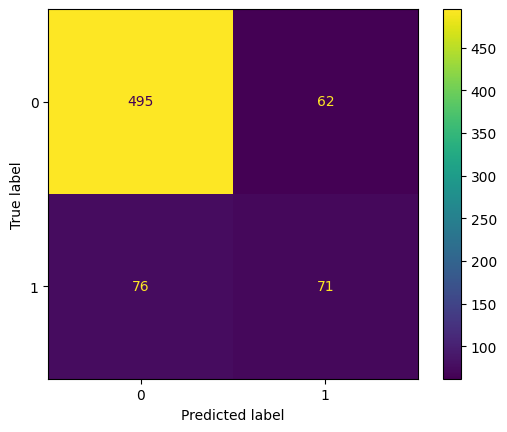

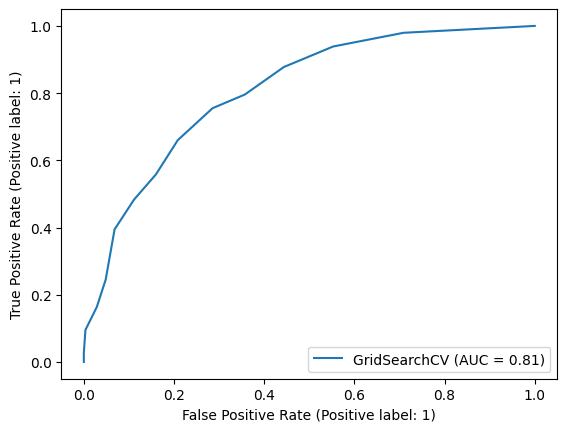

In [43]:
get_params_and_predict_model(grid_model, X_test, y_test)

## Машина опорных векторов

In [44]:
svc = SVC()
C = np.logspace(-4, 4, 5)
gamma = ['scale', 'auto']

In [45]:
params = {'C': C, 'gamma': gamma}

In [46]:
grid_model = GridSearchCV(svc, param_grid=params)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'gamma': ['scale', 'auto']})

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       557
           1       0.59      0.41      0.48       147

    accuracy                           0.82       704
   macro avg       0.72      0.67      0.69       704
weighted avg       0.80      0.82      0.80       704



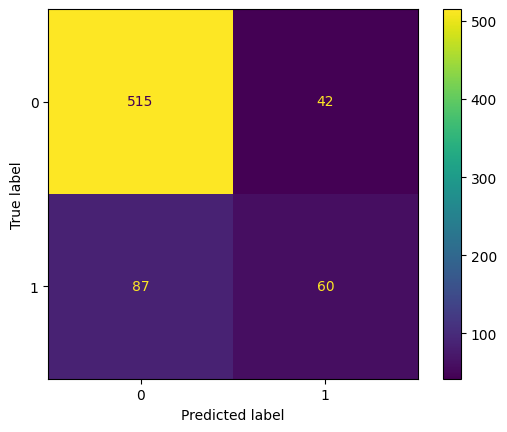

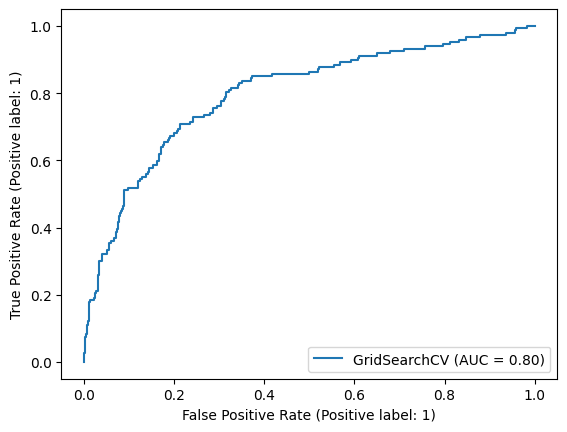

In [47]:
get_params_and_predict_model(grid_model, X_test, y_test)

## Дерево решений

In [48]:
tree = DecisionTreeClassifier()
max_depth = [i for i in range(16)]
class_weight = ['balanced', None]
max_features = [i for i in range(31)]

In [49]:
params = {'max_depth': max_depth, 'class_weight': class_weight, 'max_features': max_features}

In [51]:
grid = GridSearchCV(tree, param_grid=params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]})

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       557
           1       0.54      0.53      0.53       147

    accuracy                           0.81       704
   macro avg       0.71      0.71      0.71       704
weighted avg       0.81      0.81      0.81       704



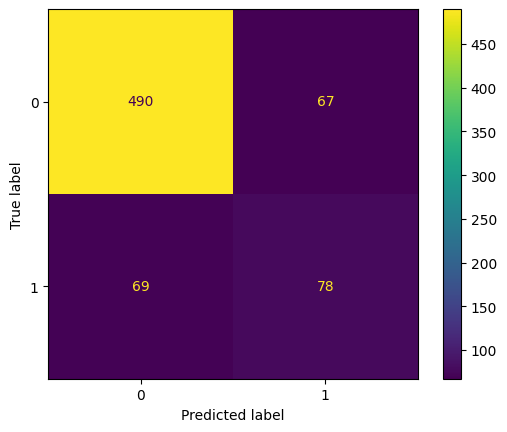

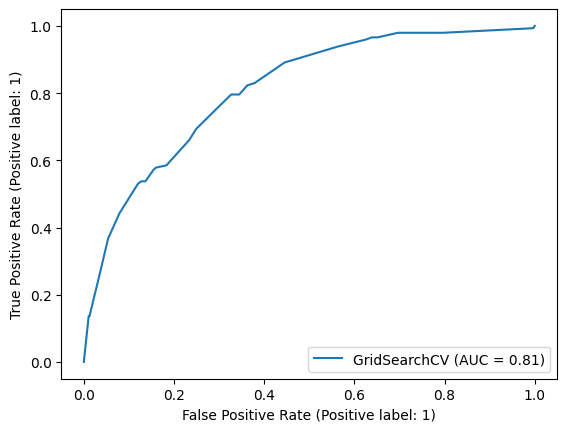

In [52]:
get_params_and_predict_model(grid, X_test, y_test)

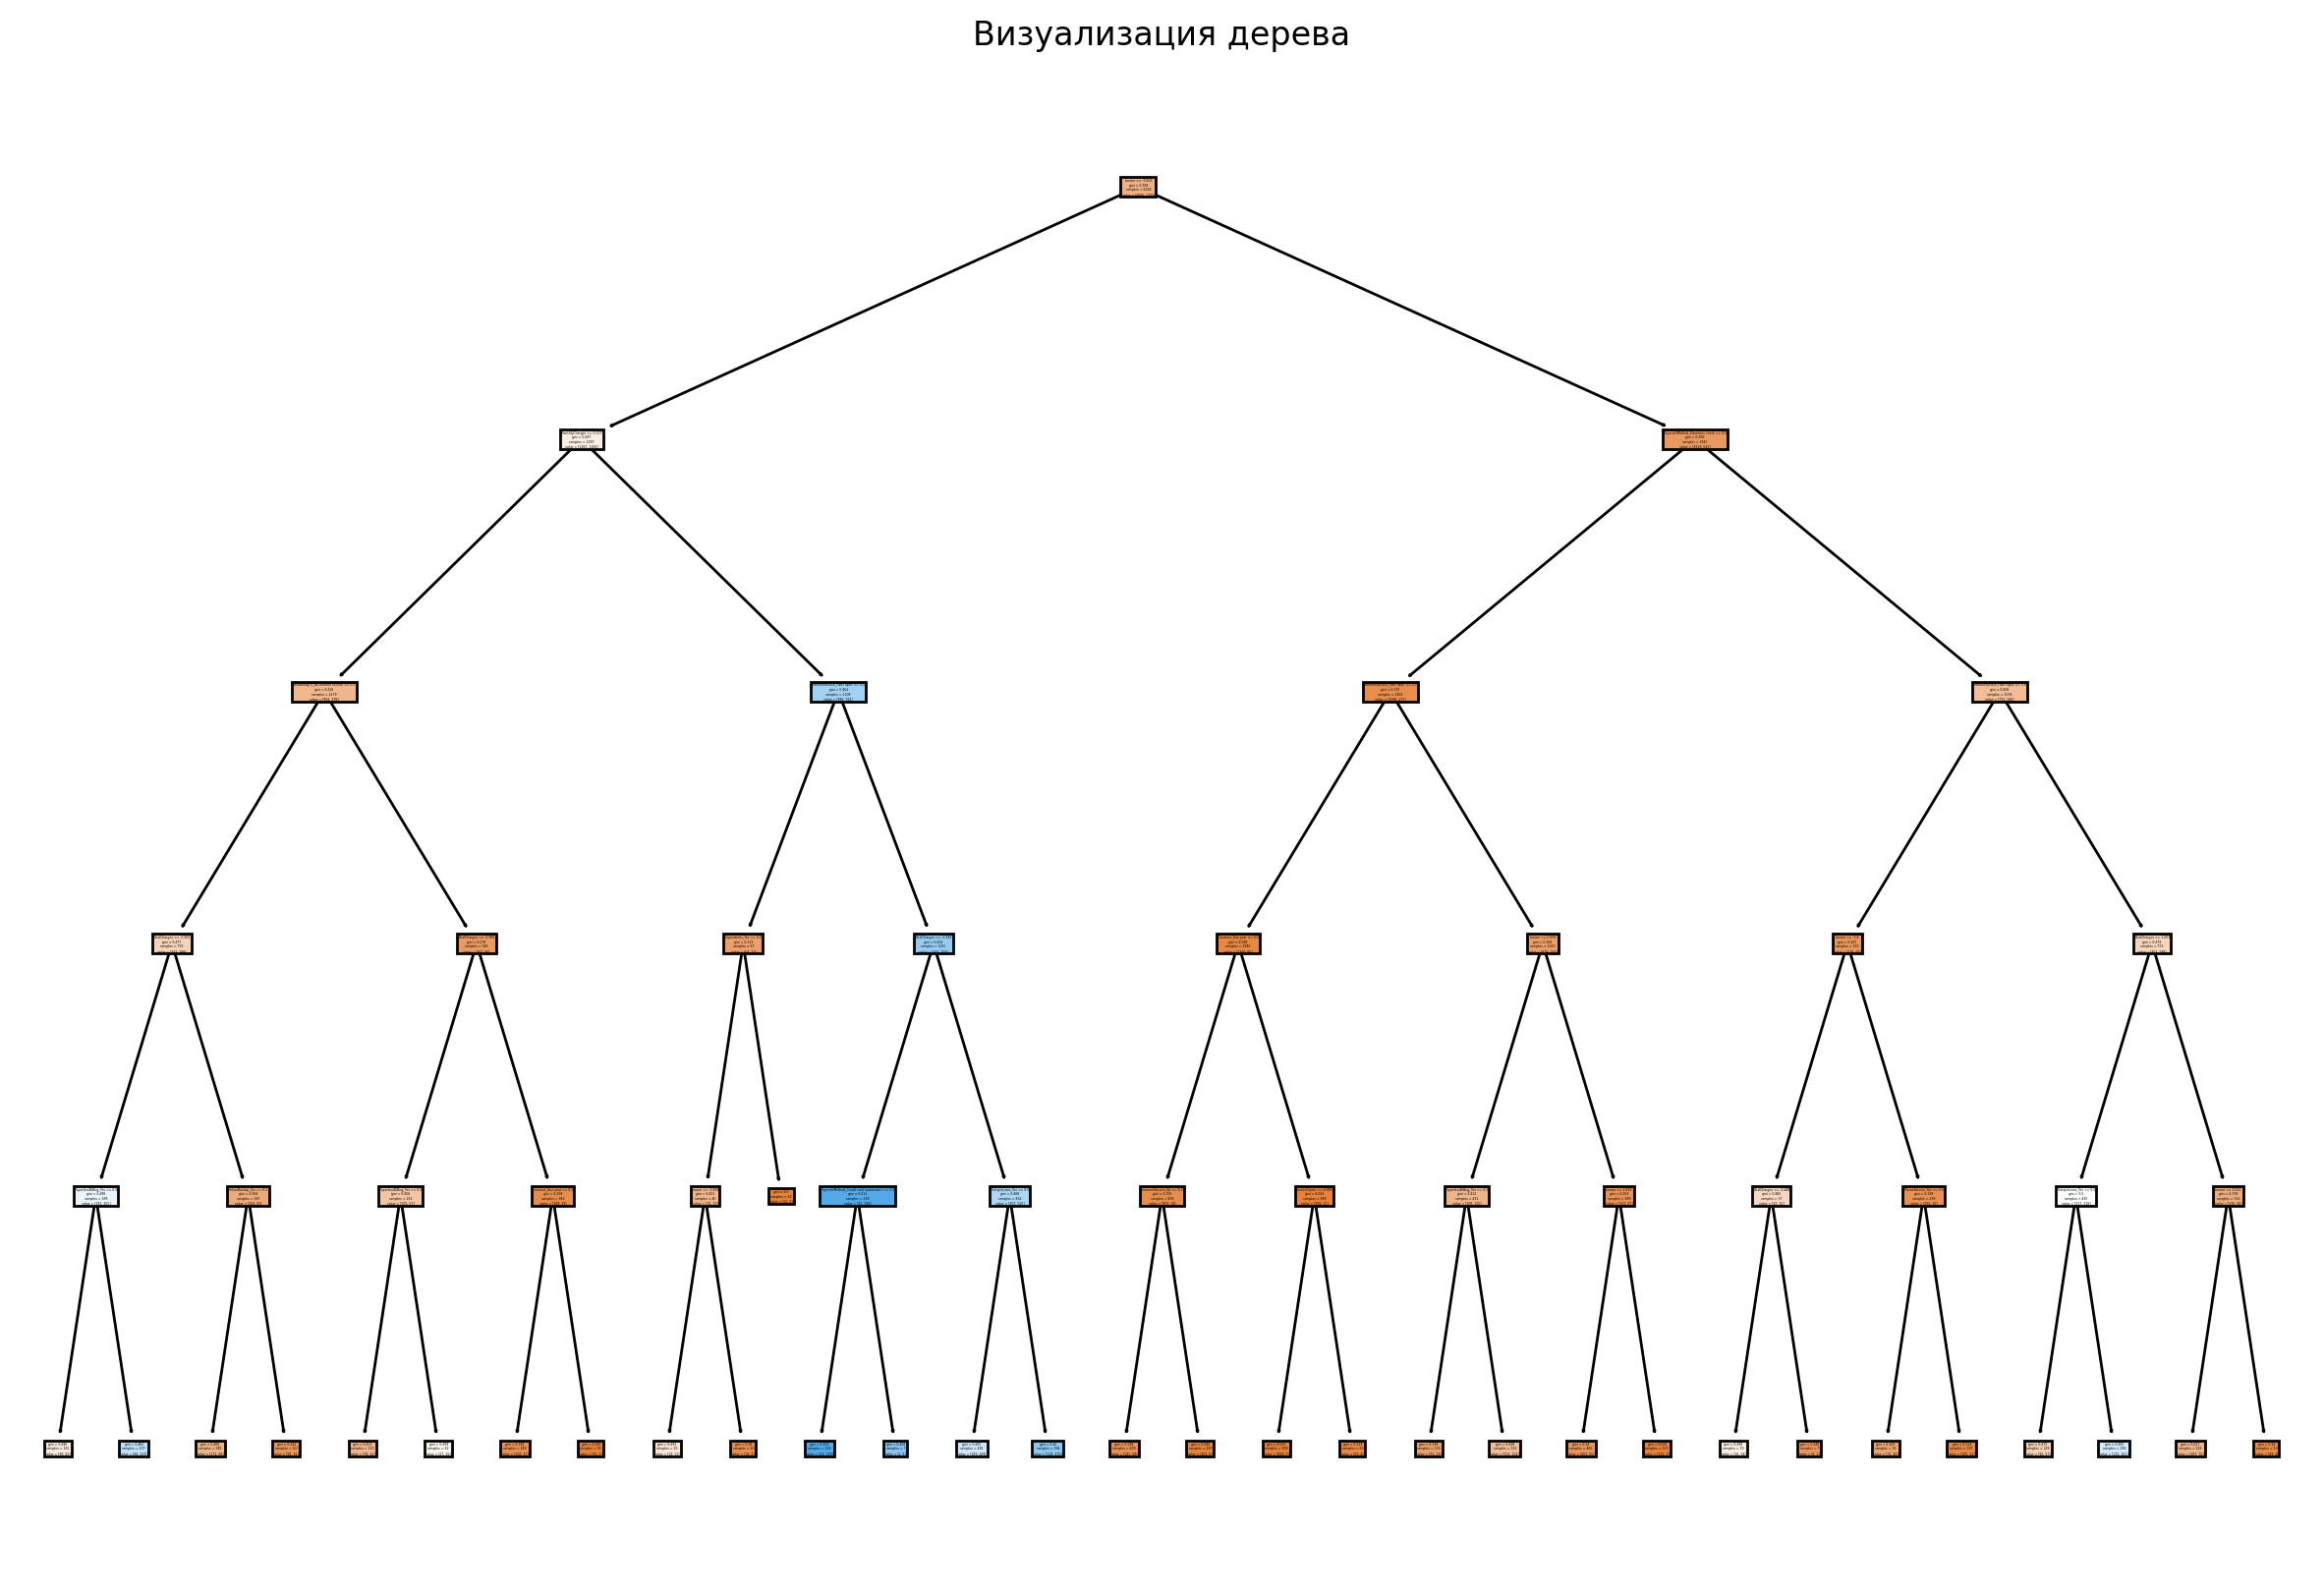

In [53]:
plt.figure(figsize=(15,10), dpi=200)
plot_tree(grid.best_estimator_, feature_names=X_train.columns, filled=True);
plt.title('Визуализация дерева');

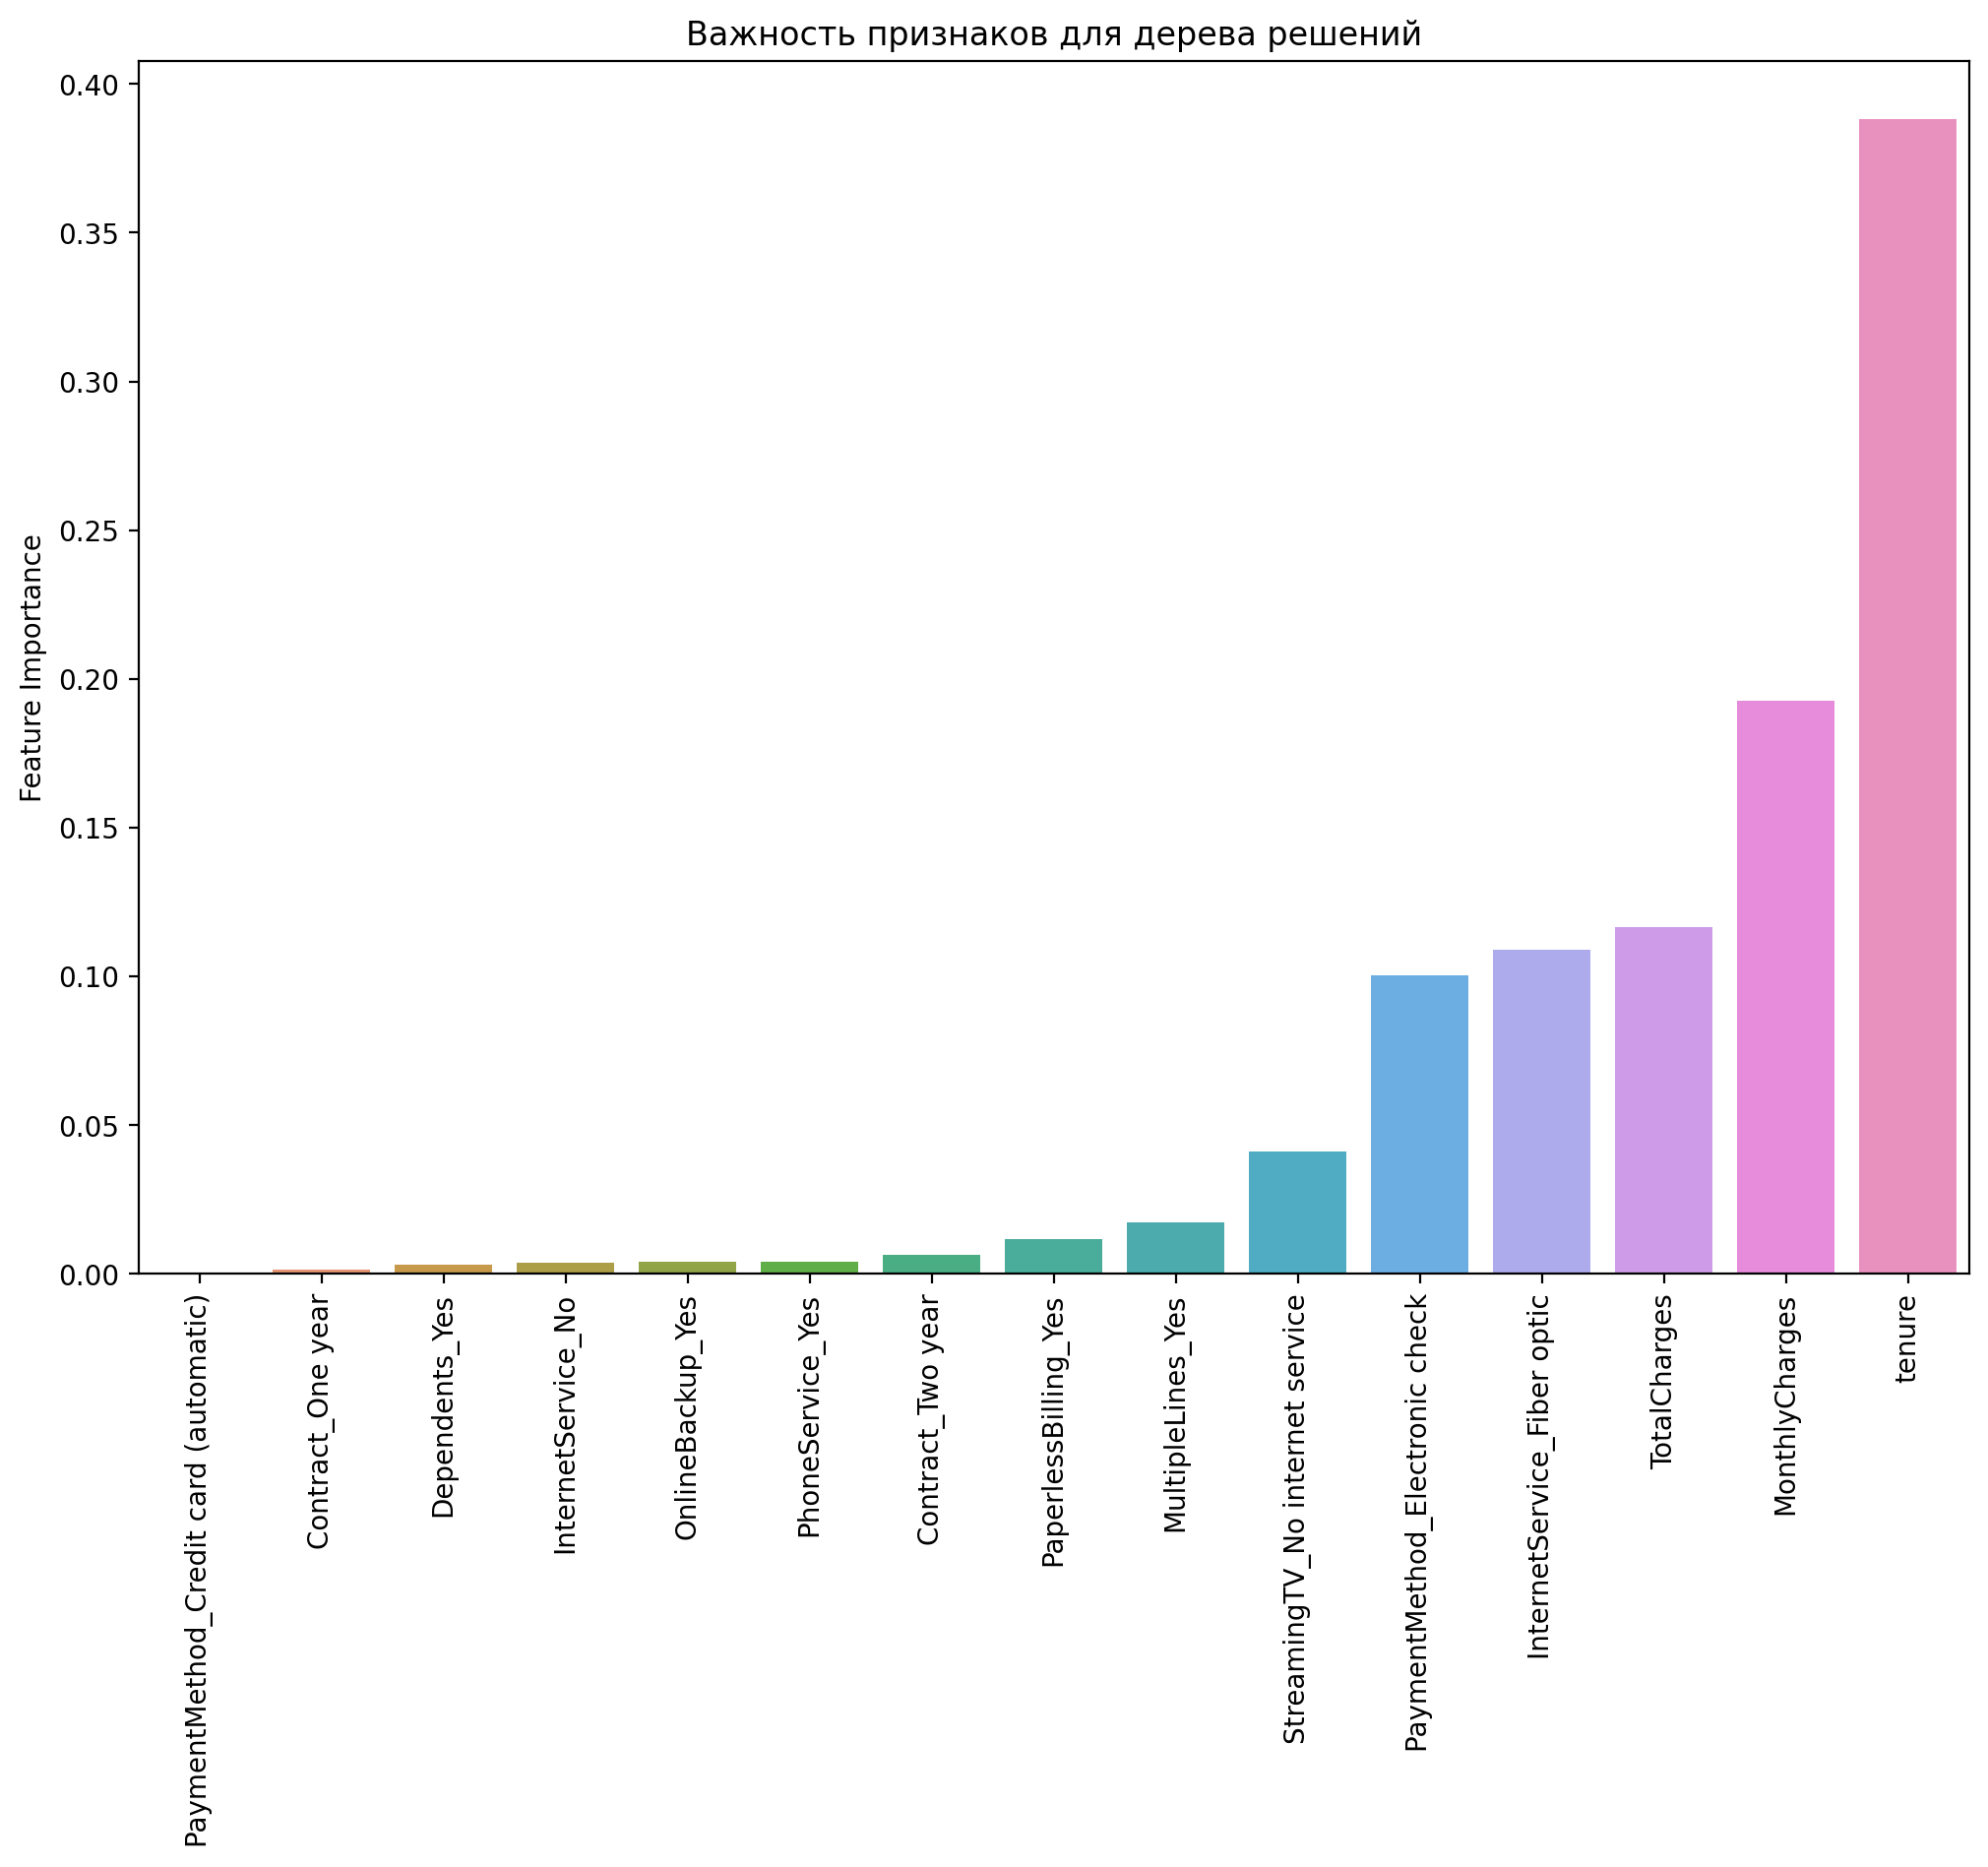

In [54]:
features = pd.DataFrame(grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values(by=0)
features = features[features[0] > 0.0005]
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(data=features, x=features.index, y=features[0])
plt.ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.title('Важность признаков для дерева решений');

 ## Случайный лес

In [55]:
rf = RandomForestClassifier()
n_estimators = [i for i in range(64, 81)]
max_features = ['sqrt', 'log2']
bootstrap = [True, False]

In [56]:
params = {'n_estimators': n_estimators, 'max_features': max_features, 'bootstrap': bootstrap}

In [57]:
grid = GridSearchCV(rf, param_grid=params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [64, 65, 66, 67, 68, 69, 70, 71, 72,
                                          73, 74, 75, 76, 77, 78, 79, 80]})

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 76, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       557
           1       0.50      0.44      0.47       147

    accuracy                           0.79       704
   macro avg       0.68      0.66      0.67       704
weighted avg       0.78      0.79      0.79       704



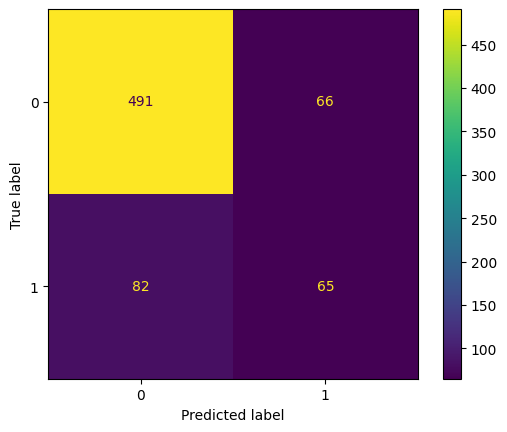

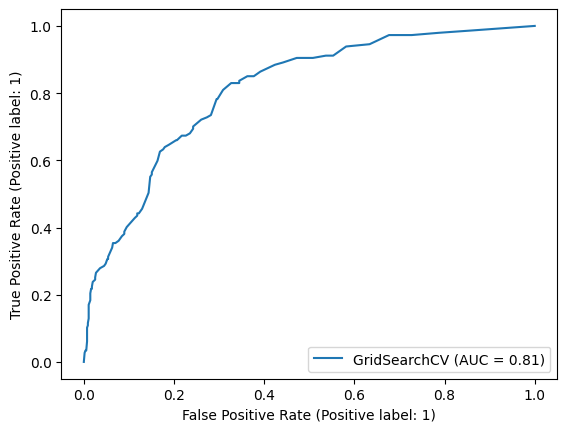

In [58]:
get_params_and_predict_model(grid, X_test, y_test)

## Ada Boosting

In [40]:
ada = AdaBoostClassifier()
n_estimators = [i for i in range(50, 101)]

In [41]:
params = {'n_estimators': n_estimators}

In [42]:
grid_model = GridSearchCV(ada, param_grid=params)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60, 61, 62, 63, 64, 65, 66, 67,
                                          68, 69, 70, 71, 72, 73, 74, 75, 76,
                                          77, 78, 79, ...]})

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 52, 'random_state': None}
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       557
           1       0.62      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.75      0.72      0.74       704
weighted avg       0.83      0.83      0.83       704



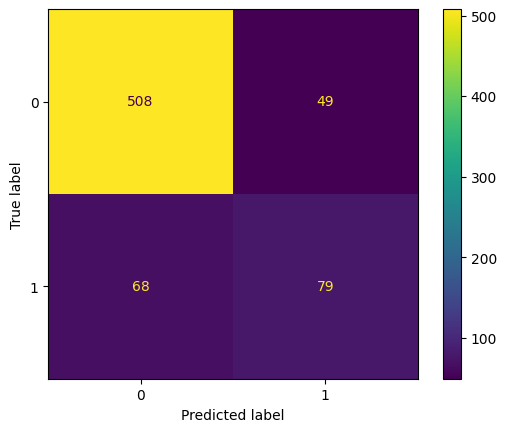

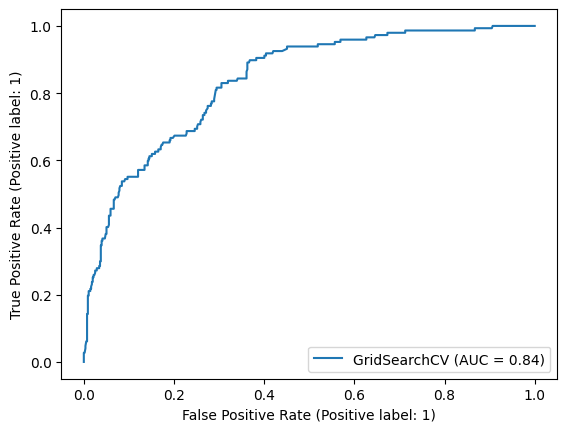

In [43]:
get_params_and_predict_model(grid_model, X_test, y_test)

In [44]:
joblib.dump(grid_model, "AdaBoosting.joblib")

['AdaBoosting.joblib']

In [45]:
model = joblib.load('AdaBoosting.joblib')

In [46]:
massive = []
for i in X_test.iloc[0, ::]:
    massive.append(i)

In [47]:
massive

[-0.4200106653398943,
 0.7949372802697402,
 -0.17110085710549214,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0]

In [48]:
model.predict([massive])

array([1], dtype=int64)

In [68]:
X_test.iloc[0]

tenure                                  -0.420011
MonthlyCharges                           0.794937
TotalCharges                            -0.171101
gender_Male                              1.000000
SeniorCitizen_1                          0.000000
Partner_Yes                              1.000000
Dependents_Yes                           1.000000
PhoneService_Yes                         1.000000
MultipleLines_No phone service           0.000000
MultipleLines_Yes                        1.000000
InternetService_Fiber optic              1.000000
InternetService_No                       0.000000
OnlineSecurity_No internet service       0.000000
OnlineSecurity_Yes                       0.000000
OnlineBackup_No internet service         0.000000
OnlineBackup_Yes                         0.000000
DeviceProtection_No internet service     0.000000
DeviceProtection_Yes                     1.000000
TechSupport_No internet service          0.000000
TechSupport_Yes                          0.000000


In [60]:
df.iloc[4246]

customerID                9054-FOWNV
gender                          Male
SeniorCitizen                      0
Partner                          Yes
Dependents                       Yes
tenure                            22
PhoneService                     Yes
MultipleLines                    Yes
InternetService          Fiber optic
OnlineSecurity                    No
OnlineBackup                      No
DeviceProtection                 Yes
TechSupport                       No
StreamingTV                      Yes
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 88.75
TotalCharges                 1885.15
Churn                              0
Tenure Cohort           12-24 Months
Name: 4246, dtype: object

In [77]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [79]:
transform = scaler.transform([[22, 88.75, 1885.15]])

In [82]:
transform

array([[-0.42001067,  0.79493728, -0.17110086]])

## Gradient Boosting

In [63]:
gd_tree = GradientBoostingClassifier()
n_estimators = [i for i in range(50, 61)]
max_depth = [3, 4, 5]
learning_rate = [0.05, 0.1, 0.2, 0.5, 1]

In [64]:
params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate}

In [65]:
grid_model = GridSearchCV(gd_tree, param_grid=params)
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60]})

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 51, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       557
           1       0.60      0.49      0.54       147

    accuracy                           0.82       704
   macro avg       0.73      0.70      0.71       704
weighted avg       0.81      0.82      0.82       704



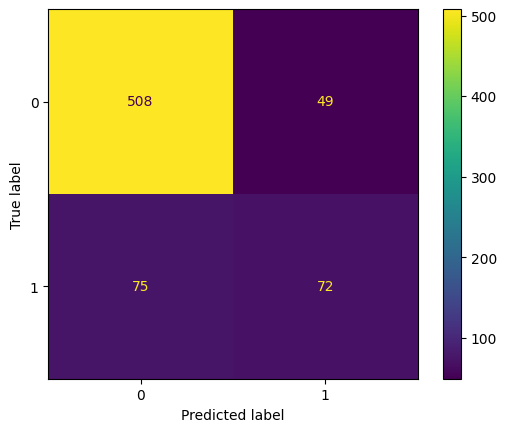

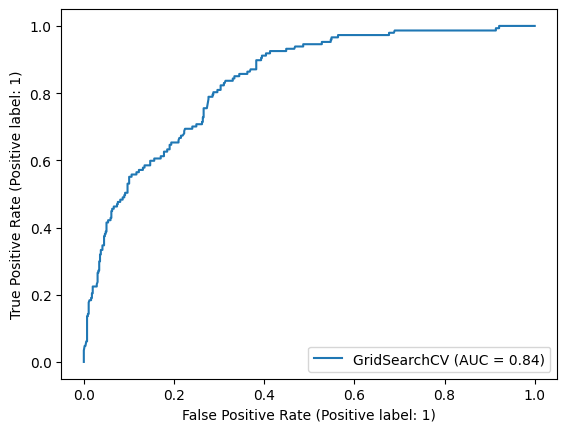

In [66]:
get_params_and_predict_model(grid_model, X_test, y_test)

# Итог

**Можно сказать, что модель AdaBoost справилась с задачей лучше всего. Во-первых, она имеет самый высокий показатель accuracy - 0,83. Во-вторых, нам необходимо было, исходя из контекста задачи, стремиться уменьшить количество людей, для которых модель предсказала, что они остались, хотя на самом деле они ушли от оператора (показатель FP в матрице ошибок). Модель AdaBoost как раз предсказала наименьшее количество таких людей - 68.** 